In [5]:
import pandas as pd
import numpy as np
import os
import json
import pandas_datareader.data as web   # my local kernel Python 3.10.7 
import matplotlib.pyplot as plt  # unavailable?  do: 1. pip uninstall matplotlib # 2. python3 -m pip install matplotlib
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime
import io
pd.set_option('display.max_columns', None)
# import warnings
import seaborn as sns
import scipy
from scipy import stats
# warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import talib as ta
import scipy
from scipy import stats
import mplfinance as mpf
# from library.sb_utils import save_file
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.set_option('display.max_rows', 100)  # Display up to 100 rows
pd.set_option('display.max_columns', 50)  # Display up to 50 columns
pd.set_option('display.max_colwidth',100)  # Display up to 100 characters per column value

# !pip install plotly
import plotly

In [6]:
directory_path =  r"C:\Repo\U_55"   
dfs = []
for file in os.listdir(directory_path):
    if file.endswith('.pickle'):
        df = pd.read_pickle(os.path.join(directory_path, file))
        dfs.append(df)
up_df = pd.concat(dfs, axis= 0)


In [7]:
up_df

,Vol,BidAsk,open,high,low,close,day,type
2022-12-12 04:20:00,236.0,32.0,3967.25,3968.25,3967.25,3967.50,Up,5
2022-12-12 04:22:00,238.0,-26.0,3967.50,3967.50,3966.00,3966.00,Up,5
2022-12-12 04:24:00,275.0,1.0,3966.00,3967.00,3965.50,3966.50,Up,5
2022-12-12 04:26:00,293.0,22.0,3966.50,3966.75,3965.75,3966.25,Up,5
2022-12-12 04:28:00,388.0,1.0,3966.25,3967.00,3965.75,3966.50,Up,5
...,...,...,...,...,...,...,...,...
2022-12-02 16:22:00,86.0,-20.0,12000.00,12001.00,11998.00,11998.50,Up,5
2022-12-02 16:24:00,327.0,-131.0,11998.50,12000.00,11995.00,12000.00,Up,5
2022-12-02 16:26:00,228.0,-155.0,11999.75,12000.00,11994.25,11994.75,Up,5
2022-12-02 16:28:00,267.0,-118.0,11994.50,11994.50,11990.25,11991.75,Up,5


# NQ Up
- Feature Engineering

In [ ]:
nqUp = up_df[up_df['close'] > 6000]

# Calculate OnBalanceVolume indicator and OnBalanceBidAsk indicator
OBV = []
OBV.append(0)
for i in range(1, len(nqUp.close)):
    if nqUp.close[i] > nqUp.close[i-1]: # If the closing price is above the prior close price 
          OBV.append(OBV[-1] + nqUp.Vol[i]) # then: Current OBV = Previous OBV + Current Volume
    elif nqUp.close[i] < nqUp.close[i-1]:
          OBV.append( OBV[-1] - nqUp.Vol[i])
    else:
          OBV.append(OBV[-1])
          
obBA = []
obBA.append(0)
for i in range(1, len(nqUp.close)):
    if nqUp.close[i] > nqUp.close[i-1]: # If the closing price is above the prior close price 
          obBA.append(obBA[-1] + nqUp.BidAsk[i]) # then: Current OBV = Previous OBV + Current Volume
    elif nqUp.close[i] < nqUp.close[i-1]:
          obBA.append( obBA[-1] - nqUp.BidAsk[i])
    else:
          obBA.append(obBA[-1])

nqUp['vari'] = nqUp.close - nqUp.open
nqUp['volat'] = nqUp.high - nqUp.low
nqUp['taly'] = nqUp.Vol - nqUp.BidAsk

nqUp['diff'] = (nqUp.close.diff()).fillna(method='bfill') 
nqUp['pct_chng'] = nqUp.close.pct_change().fillna(method='bfill') * 100  
nqUp['fut_10'] = (nqUp.close.shift(-10) - nqUp.close).fillna(method='ffill')
nqUp['fut_5'] = (nqUp.close.shift(-5) - nqUp.close).fillna(method='ffill')
nqUp["volatility"] = (nqUp["pct_chng"].rolling(window= 2).std() * 100).fillna(method='bfill')    
nqUp['BA_2m'] = (nqUp['BidAsk'].rolling(2).mean()).fillna(method='bfill')  
nqUp['BA_5m'] = (nqUp['BidAsk'].rolling(5).mean()).fillna(method='bfill')  
nqUp['BA_10m'] = (nqUp['BidAsk'].rolling(10).mean()).fillna(method='bfill')  

nqUp['BA_cs'] = nqUp.BidAsk.cumsum()
nqUp['BAr_V'] = (nqUp.BidAsk.rolling(3).sum() - nqUp.Vol).fillna(method='bfill')


nqUp['vwap'] = (nqUp.Vol * (nqUp.high + nqUp.low) / 2).cumsum() / nqUp.Vol.cumsum() 
nqUp['vwapBA'] = ((nqUp.Vol * (nqUp.high + nqUp.low) / 2).cumsum() / nqUp.Vol.cumsum() ) / nqUp['taly']
nqUp['typeD'] = -0.5

nqUp['OBV'] = OBV
nqUp['obBA'] = obBA

nqUp= nqUp.replace([np.inf, -np.inf], np.finfo(np.float64).max)
mask = nqUp.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
print(f'Total number of infinite values: {inf_count}') # Total number of infinite values: 0 
nqUp.replace([np.inf, -np.inf], np.nan, inplace=True)
nqUp= nqUp.replace([np.inf, -np.inf], np.finfo(np.float64).min)

print(nqUp.shape)   # (8052, 26)
nqUp.head()
# nqUp.tail()
# nqUp.head()
# nqUp.sample()
nqdays = nqUp.groupby(nqUp.index.to_period('D')).ngroups # 27
print('NQ days are ', nqdays)  #  NQ days are  27
# Total number of infinite values: 0
# (9882, 26)


In [ ]:
# Old features
# nqUp = up_df[up_df['close'] > 6000]
# del nqUp['type']


# nqUp['typeD'] = 0.5
# nqUp['vari'] = nqUp.close - nqUp.open
# nqUp['volat'] = nqUp.high - nqUp.low
# nqUp['taly'] = nqUp.Vol - nqUp.BidAsk
# nqUp['taly2'] = (nqUp.Vol / nqUp.BidAsk).interpolate(method='linear')
# nqUp['diff'] = (nqUp.close.diff()).fillna(method='bfill')
# nqUp['pct_chng'] = nqUp.close.pct_change().fillna(method='bfill') * 100
# nqUp['fut_10'] = (nqUp.close.shift(-10) - nqUp.close).fillna(method='ffill')
# nqUp['fut_5'] = (nqUp.close.shift(-5) - nqUp.close).fillna(method='ffill')
# nqUp["volatility"] = (nqUp["pct_chng"].rolling(window= 2).std() * 100).fillna(method='bfill')    
# nqUp['BA_2m'] = (nqUp['BidAsk'].rolling(2).mean()).fillna(method='bfill')  
# nqUp['BA_5m'] = (nqUp['BidAsk'].rolling(5).mean()).fillna(method='bfill')  
# nqUp['BA_10m'] = (nqUp['BidAsk'].rolling(10).mean()).fillna(method='bfill')  
# nqUp['chng'] = nqUp.volat / nqUp['pct_chng'].replace([np.inf, -np.inf], 0).fillna(method='ffill')
# nqUp['vwap'] = (nqUp.Vol * (nqUp.high + nqUp.low) / 2).cumsum() / nqUp.Vol.cumsum() 
# nqUp['vwapBA'] = ((nqUp.Vol * (nqUp.high + nqUp.low) / 2).cumsum() / nqUp.Vol.cumsum() ) / nqUp['taly']


# mask = nqUp.isin([np.inf, -np.inf])
# inf_count = mask.values.sum()
# print(f'Total number of infinite values: {inf_count}') # Total number of infinite values: 733 ;   ----  after =  0
# nqUp.replace([np.inf, -np.inf], np.nan, inplace=True)
# nqUp = nqUp.replace([np.inf, -np.inf], np.finfo(np.float64).min)
# nqUp['BA_cs'] = nqUp.BidAsk.cumsum()
# nqUp['BAr_V'] = (nqUp.BidAsk.rolling(3).sum() - nqUp.Vol).fillna(method='bfill')
# nqUp.head()
# nqUp.tail()
# nqUp.sample()
# nqdays = nqUp.groupby(nqUp.index.to_period('D')).ngroups # 27
# print('NQ days are ', nqdays)
# nqUp.shape   # (9882, 25)

In [55]:
# del nqUp['type']
# del nqUp['typeD']

nqUp.head() 
# nqUp.shape  #(9882, 23)

,Vol,BidAsk,open,high,low,close,vari,volat,taly,diff,pct_chng,fut_10,fut_5,volatility,BA_2m,BA_5m,BA_10m,BA_cs,BAr_V,vwap,vwapBA,OBV,obBA
2022-12-29 04:20:00,287.0,-9.0,10837.25,10841.50,10837.00,10838.25,1.00,4.50,296.0,4.25,0.039213,-2.75,-5.25,0.000000,15.5,-18.6,-17.5,-9.0,-278.0,10839.250000,36.619088,0.0,0.0
2022-12-29 04:22:00,248.0,40.0,10838.25,10844.00,10838.25,10842.50,4.25,5.75,208.0,4.25,0.039213,-5.00,-9.00,0.000000,15.5,-18.6,-17.5,31.0,-278.0,10840.119159,52.115957,248.0,40.0
2022-12-29 04:24:00,312.0,3.0,10842.50,10845.00,10841.00,10843.50,1.00,4.00,309.0,1.00,0.009223,-4.75,-5.75,2.120614,21.5,-18.6,-17.5,34.0,-278.0,10841.180342,35.084726,560.0,43.0
2022-12-29 04:26:00,269.0,-63.0,10844.00,10844.75,10837.00,10837.75,-6.25,7.75,332.0,-5.75,-0.053027,0.00,0.25,4.401749,-30.0,-18.6,-17.5,-29.0,-289.0,10841.106743,32.653936,291.0,106.0
2022-12-29 04:28:00,211.0,-64.0,10837.00,10838.00,10834.50,10835.50,-1.50,3.50,275.0,-2.25,-0.020761,2.25,1.75,2.281578,-63.5,-18.6,-17.5,-93.0,-335.0,10840.334495,39.419398,80.0,170.0


### Normalize 

In [57]:
idx_date = nqUp.index
len(idx_date)   #  10234
# nqUp.index = pd.to_datetime(nqUp.index) # make sure its Datetime index

# Group by day
daily_group = nqUp.groupby(nqUp.index.date)

# # Define the mean normalization scaling function
def mean_normalization(group):
    mean_value = group.mean()
    min_value = group.min()
    max_value = group.max()
    return (group - mean_value) / (max_value - min_value)

# Apply the mean normalization scaling function to each day's 'Close' values
nq_centered = daily_group.transform(mean_normalization)

# Display the resulting centered Series
# print(nq_centered)
# type(nq_centered)
nq_centered = nq_centered.sort_index()
# nq_centered.typeD = 0.5
# nq_centered.chng.interpolate(method='linear', inplace=True)


In [58]:
nq_centered.shape

(9882, 23)

In [59]:
# del nq_centered['typeD']
nq_centered.columns

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
       'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA'],
      dtype='object')

In [60]:


# (['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
#        'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
#        'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA'],
 
 # Save DataFrame to a pickle file
pickle_file = "NQ_U.pkl"
nq_centered.to_pickle(pickle_file)

# pickNQ = "NQ_U.pkl"
# loaded_df = pd.read_pickle(pickNQ)
# loaded_df.head()
# (type(loaded_df.index))


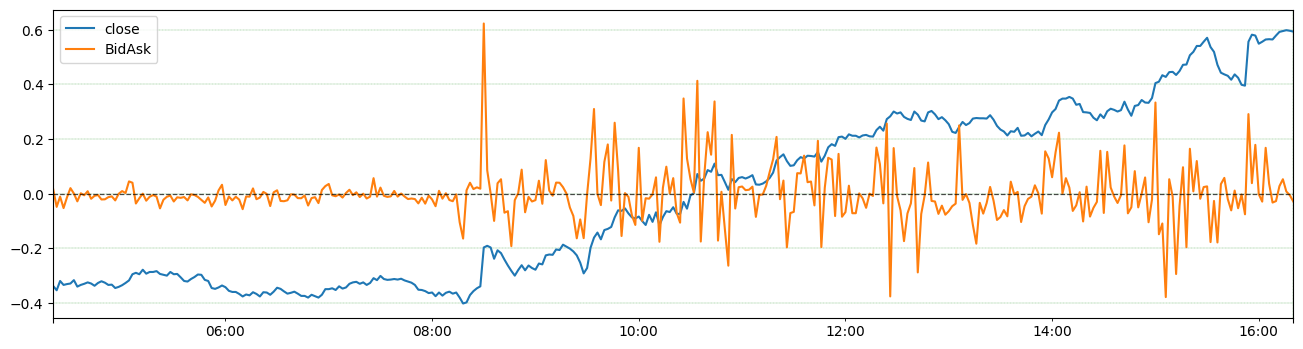

In [61]:
nq_centered['2023-03-31 04:20:00':'2023-03-31 16:20:00'].plot(y=['close', 'BidAsk'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

In [62]:
# check for infinite values
mask = nq_centered.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
# print the mask and the number of infinite values
# print(mask)
print(f'Total number of infinite values: {inf_count}') # 

Total number of infinite values: 0


In [64]:
# Identify columns with NaN values and count them
nan_columns = nq_centered.isna().any()
# Count the number of NaN values per column
nan_count = nan_columns.isna().sum()
print("Number of NaN values per column:")
print(nan_count)
# Total number of NaN values in the entire DataFrame
total_nan_count = nan_count.sum()
print("\nTotal number of NaN values in the DataFrame:", total_nan_count)

Number of NaN values per column:
0

Total number of NaN values in the DataFrame: 0


In [ ]:
# dff = nq_centered.copy()
dff.shape   #  (10234, 24)
# Calculate 30% of the number of rows in the DataFrame
# num_rows = len(dff)
# subset_size = int(0.1 * num_rows)

# Select the first 10% of the DataFrame
# subset_df = dff.iloc[:subset_size]
# subset_df.shape  # (1023, 24)
# If you want to select a random 30% of the DataFrame, you can use the sample() function:
# subset_df = dff.sample(frac= 0.3)


In [ ]:

from scipy.linalg import svd

# Function to perform SVD on a given data window
def perform_svd(window_data):
    U, s, Vt = svd(window_data)
    return pd.DataFrame(Vt.T, index=window_data.columns)

# Create  DataFrame 
# subset_df

# Set your rolling window size
window_size = 23

# Initialize an empty DataFrame to store the new time series
svd_df = pd.DataFrame(index= nq_centered.index, columns= nq_centered.columns)

# Iterate over the DataFrame with a rolling window
for i in range(len(nq_centered) - window_size + 1):
    window_data = nq_centered.iloc[i:i+window_size]
    svd_result = perform_svd(window_data)
    
    # Add the SVD result to the new DataFrame
    for col in svd_result.columns:
        svd_df.iloc[i:i+window_size, col] = svd_result.iloc[:, col].T

print(svd_df)




In [80]:
# sdf = subset_df['2022-09-19 04:20:00':'2022-09-19 16:00:00']
sdf.shape  # (351, 24)
sdf.head()
type(sdf.index)

pandas.core.indexes.datetimes.DatetimeIndex

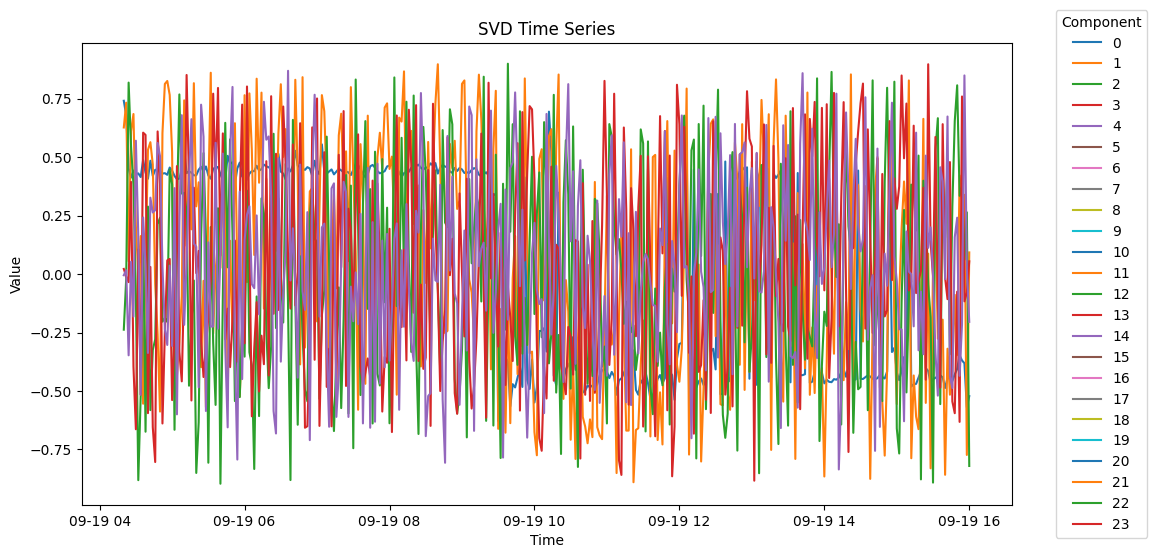

In [86]:

from scipy.linalg import svd

# Function to perform SVD on a given data window
def perform_svd(window_data):
    U, s, Vt = svd(window_data)
    return pd.DataFrame(U, index= window_data.index)  # Use the U matrix

# sdf

# Set rolling window size
window_size = 5

# Initialize an empty DataFrame to store the new time series
svd_df = pd.DataFrame(index= sdf.index, columns= np.arange(sdf.shape[1]))

# Iterate over the DataFrame with a rolling window
for i in range(len(sdf) - window_size + 1):
    window_data = sdf.iloc[i: i + window_size]
    svd_result = perform_svd(window_data)
    
    # Add the SVD result to the new DataFrame
    for col in svd_result.columns:
        svd_df.iloc[i: i+ window_size, col] = svd_result.iloc[:, col]

# print(svd_df)
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(svd_df)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("SVD Time Series")
plt.legend(svd_df.columns, title="Component", bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()


In [85]:
print(svd_result)

                            0         1         2
2022-09-19 15:56:00 -0.422588 -0.398363 -0.814080
2022-09-19 15:58:00 -0.673744  0.738870 -0.011821
2022-09-19 16:00:00 -0.606209 -0.543486  0.580632


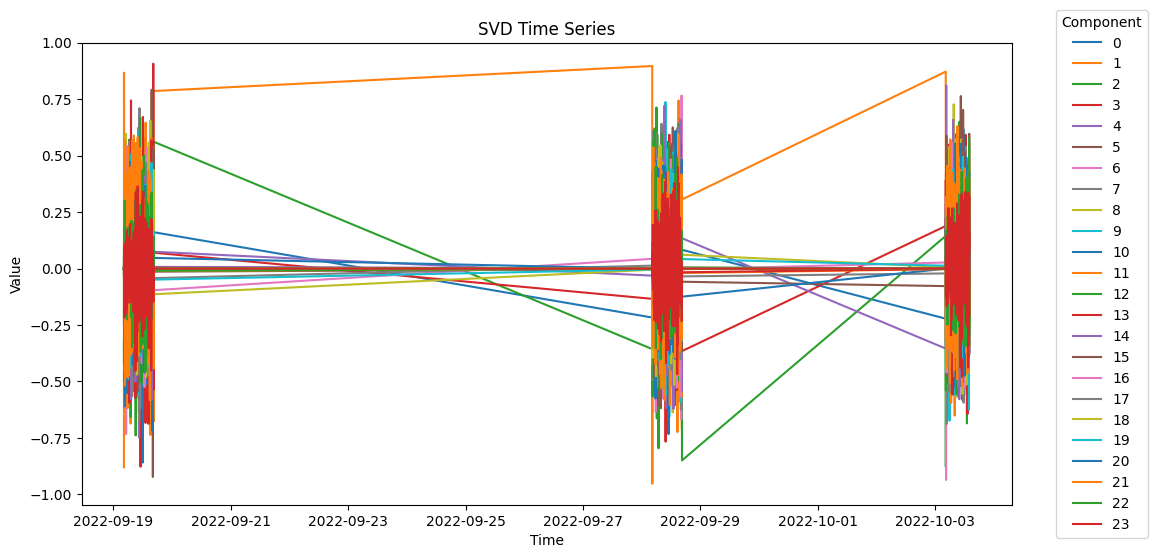

In [65]:
from scipy.linalg import svd

# Function to perform SVD on a given data window
def perform_svd(window_data):
    U, s, Vt = svd(window_data)
    return pd.DataFrame(U, index=window_data.index)

# Create your DataFrame here (I assume you already have one)
# subset_df

# Set your rolling window size
window_size = 24

# Initialize an empty DataFrame to store the new time series
svd_df = pd.DataFrame(index= subset_df.index, columns= np.arange(subset_df.shape[1]))

# Iterate over the DataFrame with a rolling window
for i in range(len(subset_df) - window_size + 1):
    window_data = subset_df.iloc[i:i+window_size]
    svd_result = perform_svd(window_data)
    
    # Add the SVD result to the new DataFrame
    for col in svd_result.columns:
        svd_df.iloc[i:i+window_size, col] = svd_result.iloc[:, col]

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(svd_df)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("SVD Time Series")
plt.legend(svd_df.columns, title="Component", bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()



Group the DataFrame by day and 30-minute intervals.
Perform SVD on each group.
Plot the SVD results in a bar plot for each group.

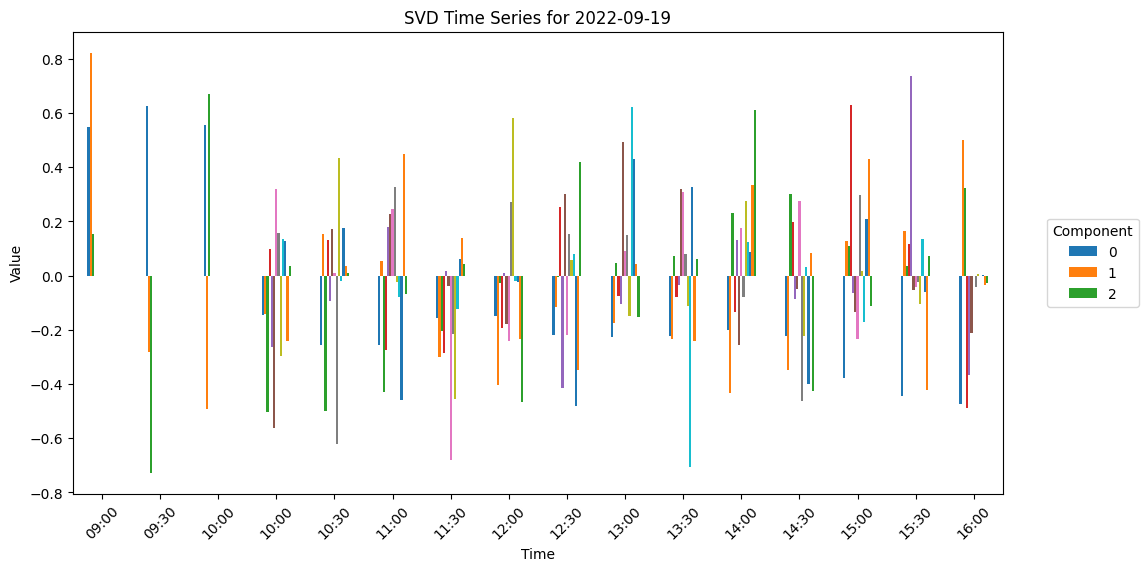

Skipping 2022-09-20 due to insufficient data
Skipping 2022-09-21 due to insufficient data
Skipping 2022-09-22 due to insufficient data
Skipping 2022-09-23 due to insufficient data
Skipping 2022-09-24 due to insufficient data
Skipping 2022-09-25 due to insufficient data
Skipping 2022-09-26 due to insufficient data
Skipping 2022-09-27 due to insufficient data


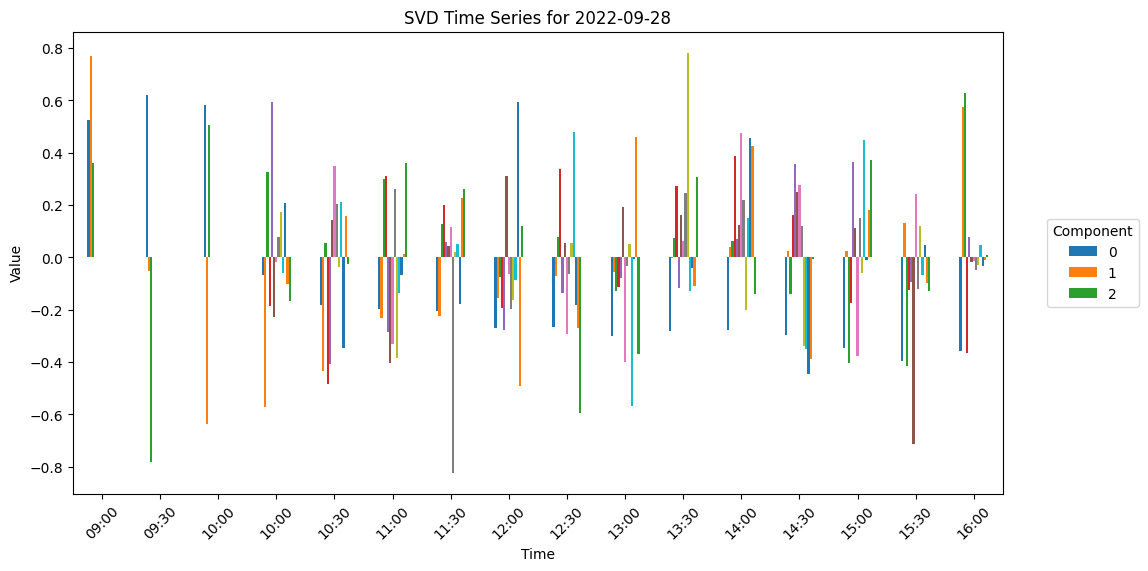

Skipping 2022-09-29 due to insufficient data
Skipping 2022-09-30 due to insufficient data
Skipping 2022-10-01 due to insufficient data
Skipping 2022-10-02 due to insufficient data


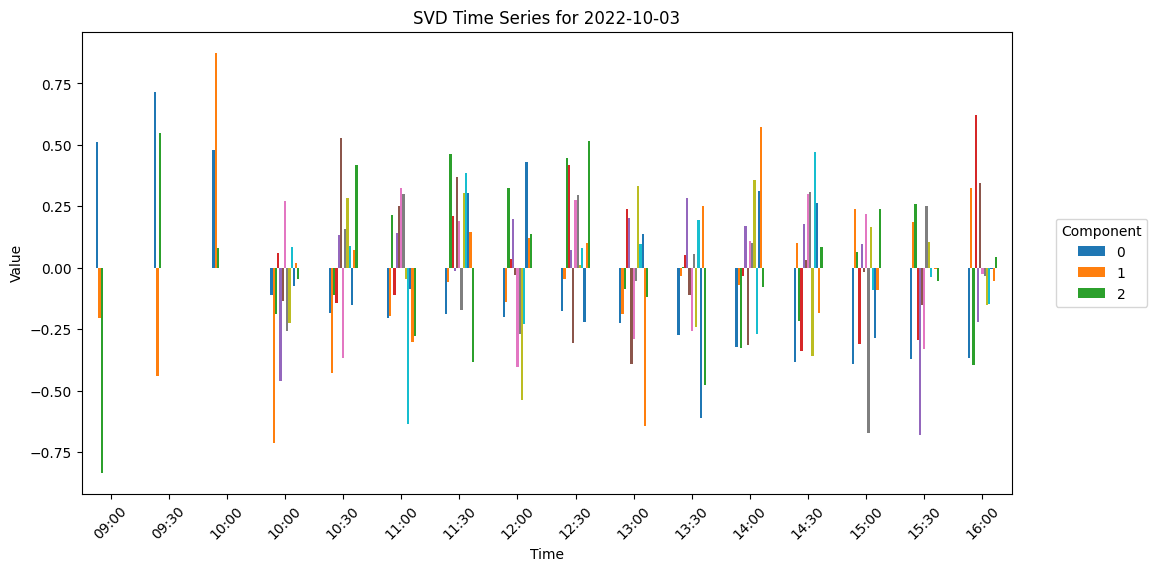

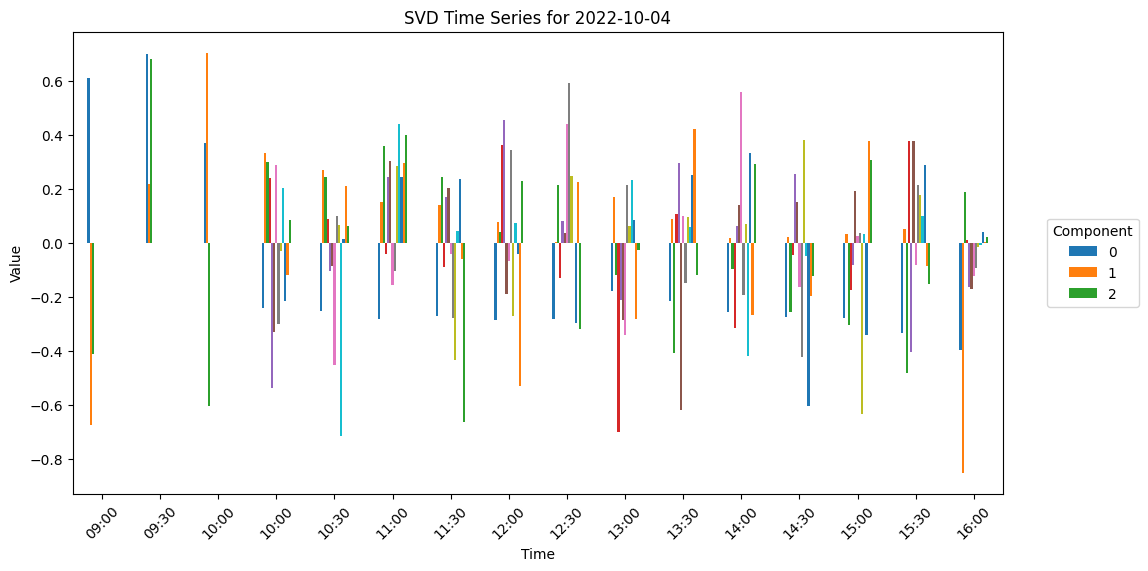

Skipping 2022-10-05 due to insufficient data
Skipping 2022-10-06 due to insufficient data
Skipping 2022-10-07 due to insufficient data
Skipping 2022-10-08 due to insufficient data
Skipping 2022-10-09 due to insufficient data
Skipping 2022-10-10 due to insufficient data
Skipping 2022-10-11 due to insufficient data
Skipping 2022-10-12 due to insufficient data


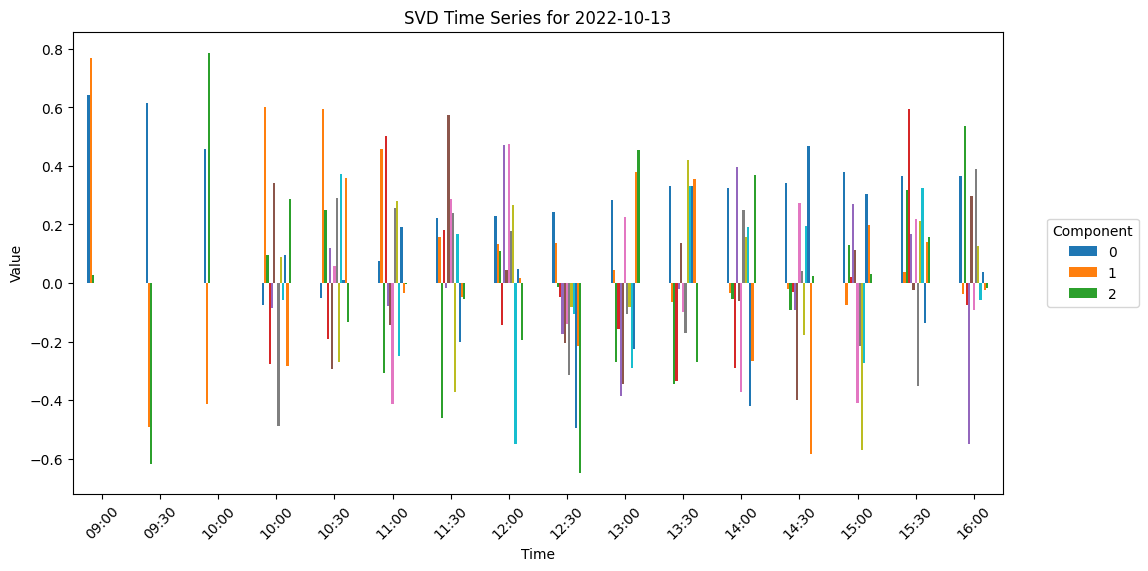

Skipping 2022-10-14 due to insufficient data
Skipping 2022-10-15 due to insufficient data
Skipping 2022-10-16 due to insufficient data


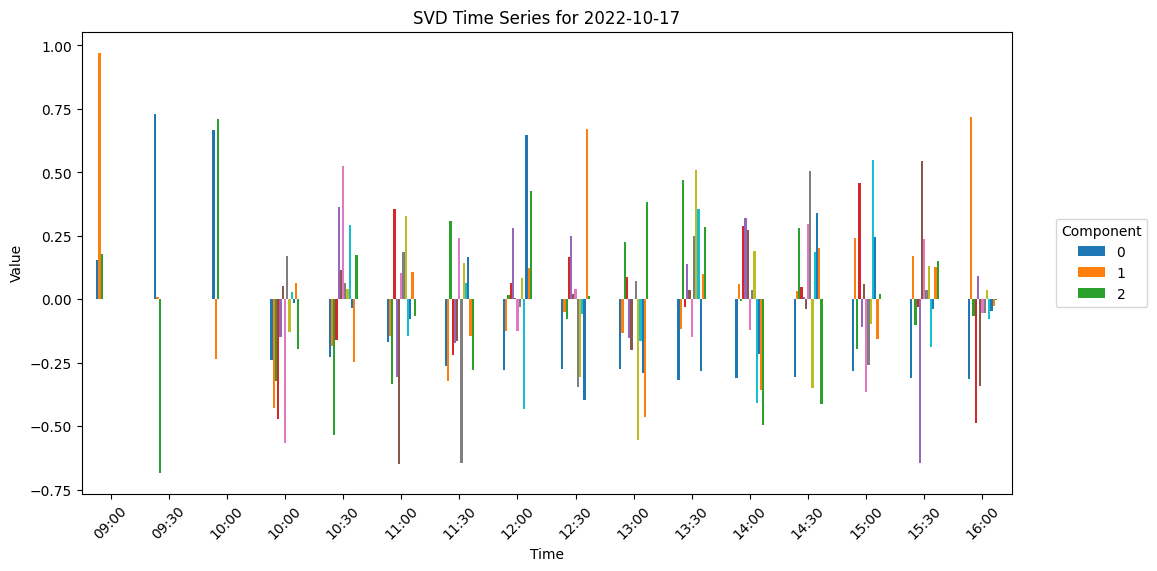

Skipping 2022-10-18 due to insufficient data
Skipping 2022-10-19 due to insufficient data
Skipping 2022-10-20 due to insufficient data


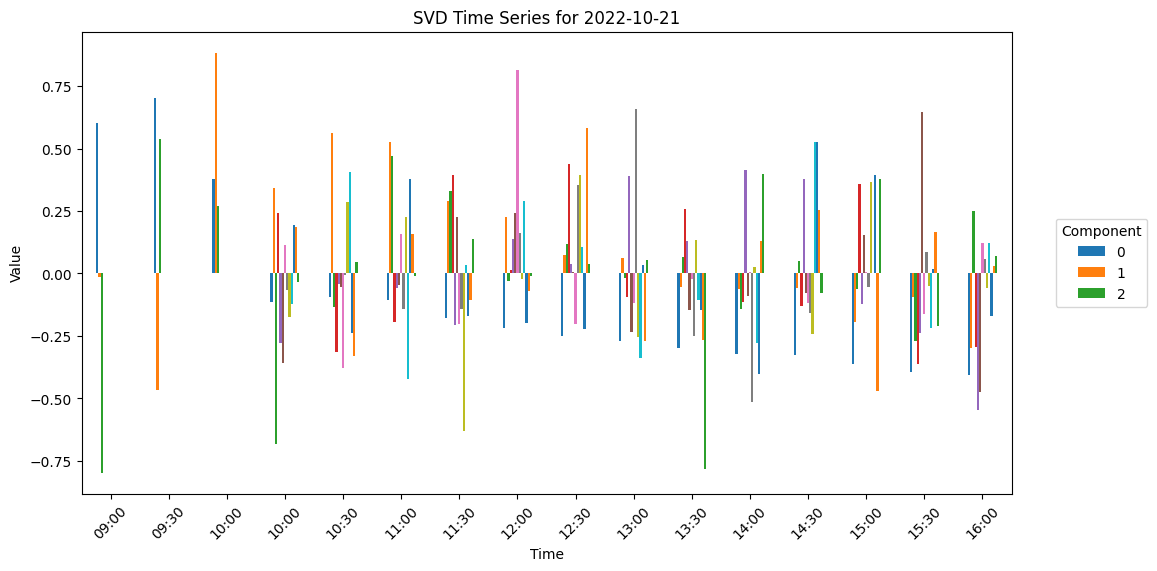

Skipping 2022-10-22 due to insufficient data
Skipping 2022-10-23 due to insufficient data
Skipping 2022-10-24 due to insufficient data


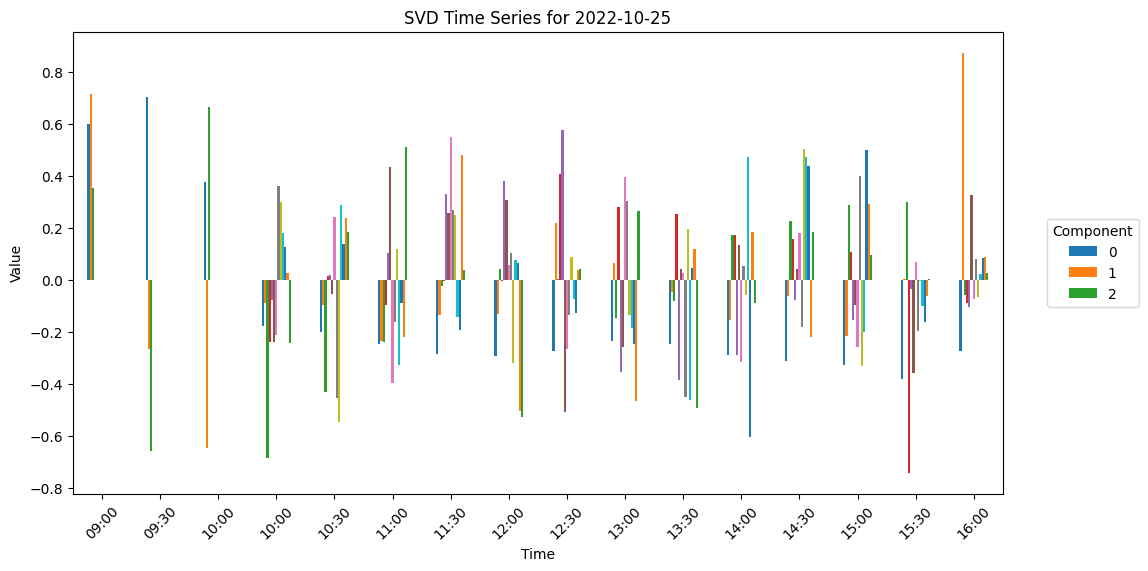

Skipping 2022-10-26 due to insufficient data
Skipping 2022-10-27 due to insufficient data


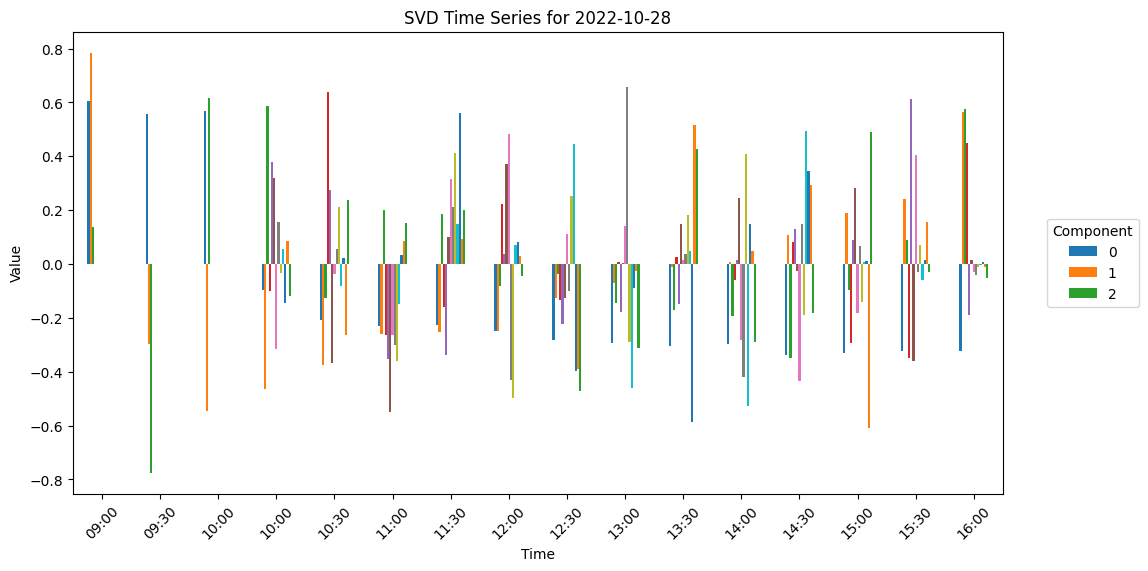

Skipping 2022-10-29 due to insufficient data
Skipping 2022-10-30 due to insufficient data
Skipping 2022-10-31 due to insufficient data
Skipping 2022-11-01 due to insufficient data
Skipping 2022-11-02 due to insufficient data
Skipping 2022-11-03 due to insufficient data
Skipping 2022-11-04 due to insufficient data
Skipping 2022-11-05 due to insufficient data
Skipping 2022-11-06 due to insufficient data
Skipping 2022-11-07 due to insufficient data
Skipping 2022-11-08 due to insufficient data
Skipping 2022-11-09 due to insufficient data


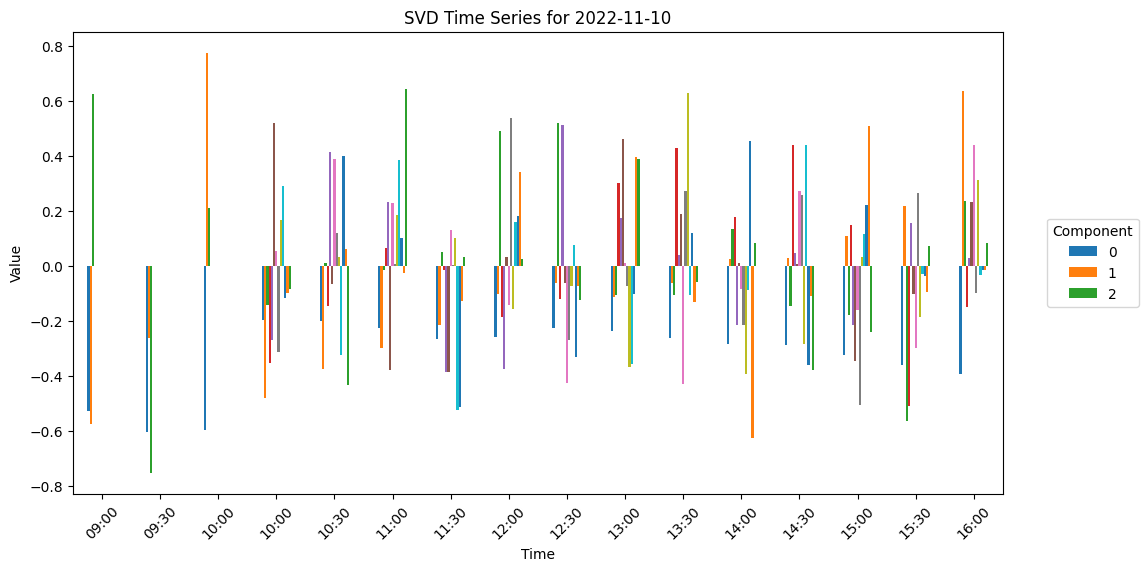

Skipping 2022-11-11 due to insufficient data
Skipping 2022-11-12 due to insufficient data
Skipping 2022-11-13 due to insufficient data
Skipping 2022-11-14 due to insufficient data
Skipping 2022-11-15 due to insufficient data
Skipping 2022-11-16 due to insufficient data
Skipping 2022-11-17 due to insufficient data
Skipping 2022-11-18 due to insufficient data
Skipping 2022-11-19 due to insufficient data
Skipping 2022-11-20 due to insufficient data
Skipping 2022-11-21 due to insufficient data


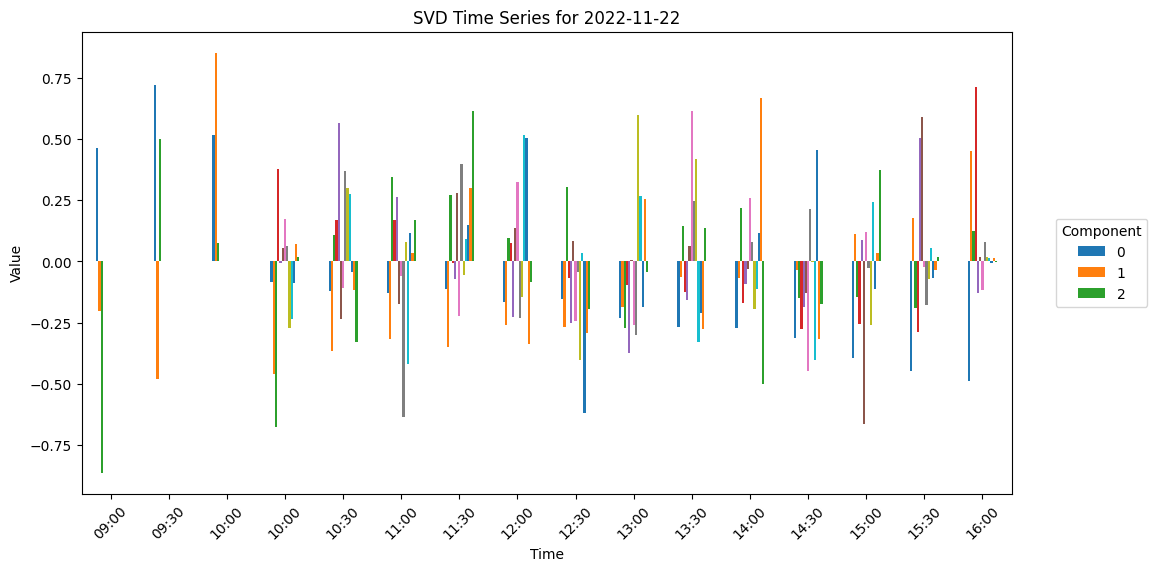

Skipping 2022-11-23 due to insufficient data
Skipping 2022-11-24 due to insufficient data
Skipping 2022-11-25 due to insufficient data
Skipping 2022-11-26 due to insufficient data
Skipping 2022-11-27 due to insufficient data
Skipping 2022-11-28 due to insufficient data
Skipping 2022-11-29 due to insufficient data


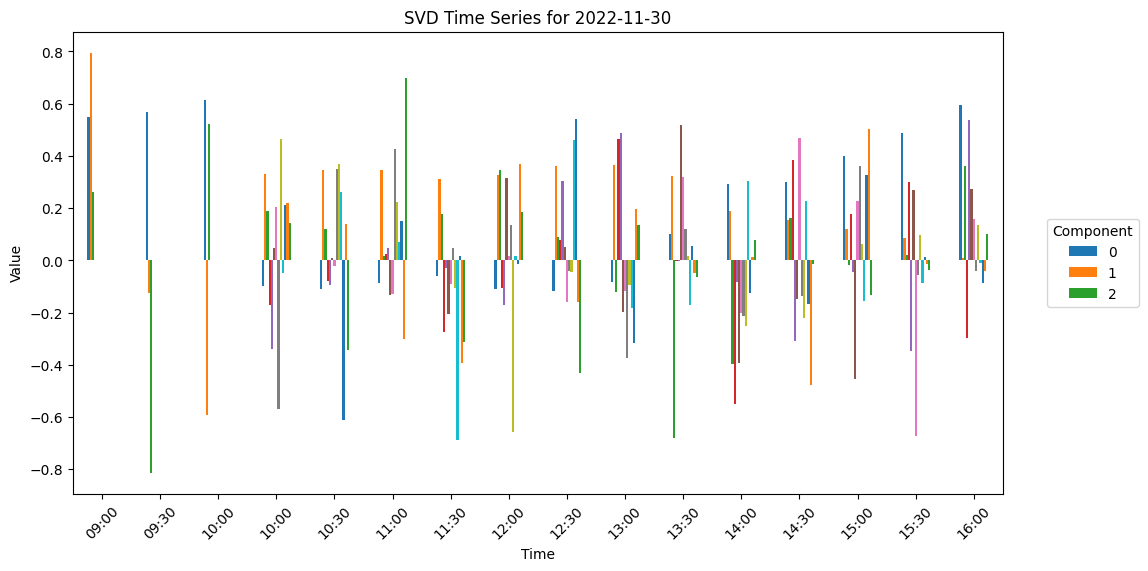

Skipping 2022-12-01 due to insufficient data


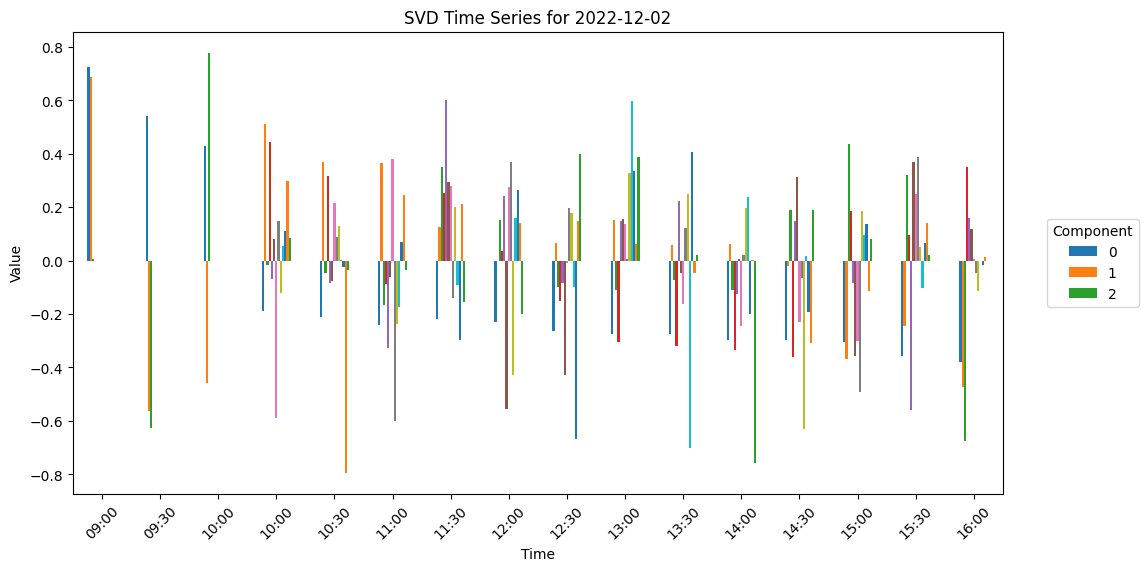

Skipping 2022-12-03 due to insufficient data
Skipping 2022-12-04 due to insufficient data
Skipping 2022-12-05 due to insufficient data
Skipping 2022-12-06 due to insufficient data
Skipping 2022-12-07 due to insufficient data
Skipping 2022-12-08 due to insufficient data
Skipping 2022-12-09 due to insufficient data
Skipping 2022-12-10 due to insufficient data
Skipping 2022-12-11 due to insufficient data


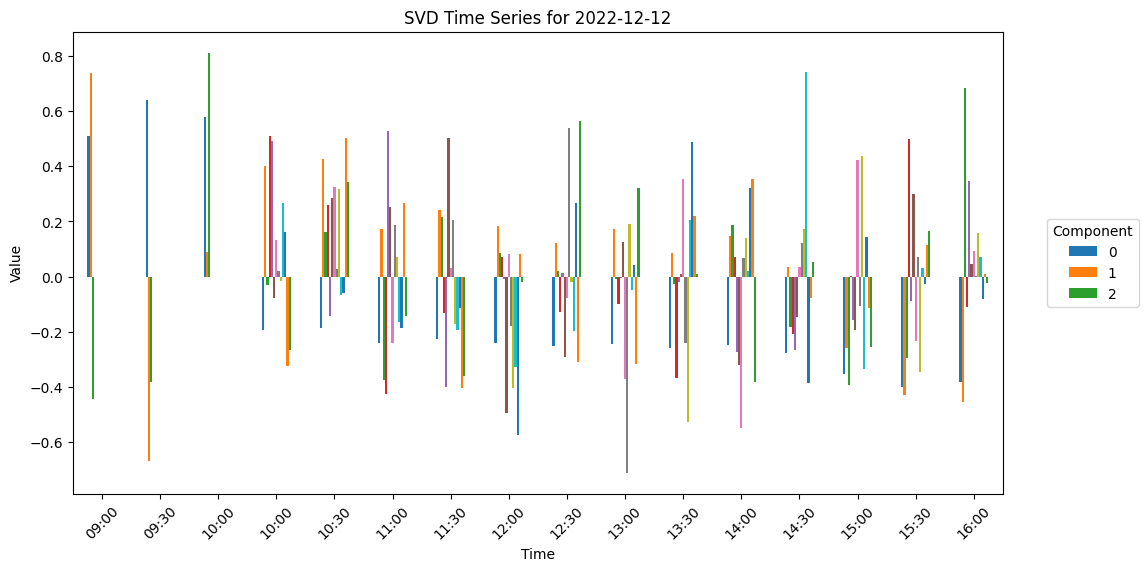

Skipping 2022-12-13 due to insufficient data
Skipping 2022-12-14 due to insufficient data
Skipping 2022-12-15 due to insufficient data
Skipping 2022-12-16 due to insufficient data
Skipping 2022-12-17 due to insufficient data
Skipping 2022-12-18 due to insufficient data
Skipping 2022-12-19 due to insufficient data
Skipping 2022-12-20 due to insufficient data


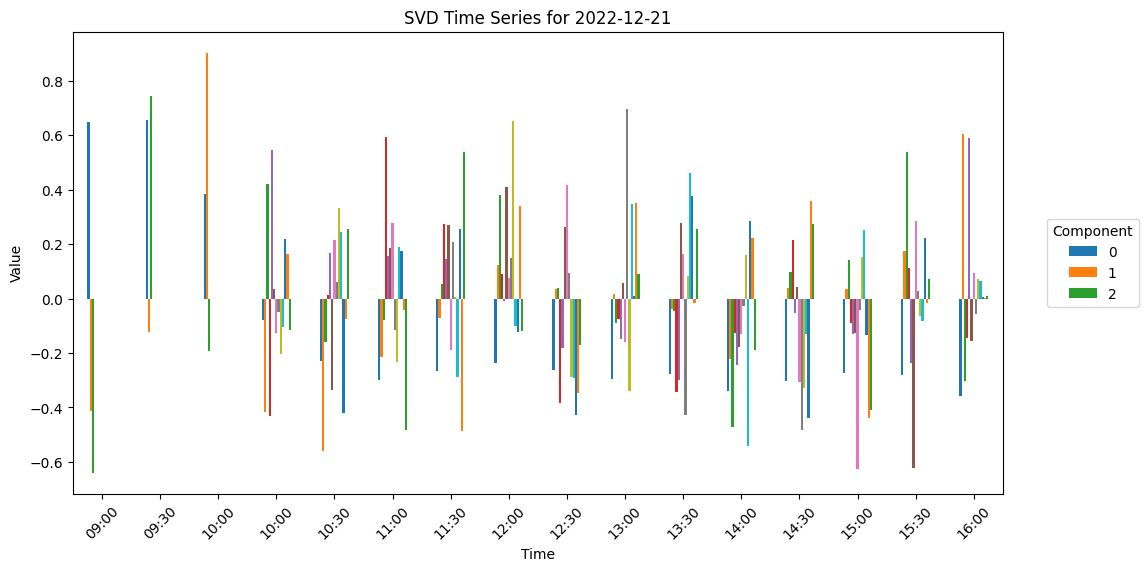

Skipping 2022-12-22 due to insufficient data
Skipping 2022-12-23 due to insufficient data
Skipping 2022-12-24 due to insufficient data
Skipping 2022-12-25 due to insufficient data
Skipping 2022-12-26 due to insufficient data
Skipping 2022-12-27 due to insufficient data
Skipping 2022-12-28 due to insufficient data


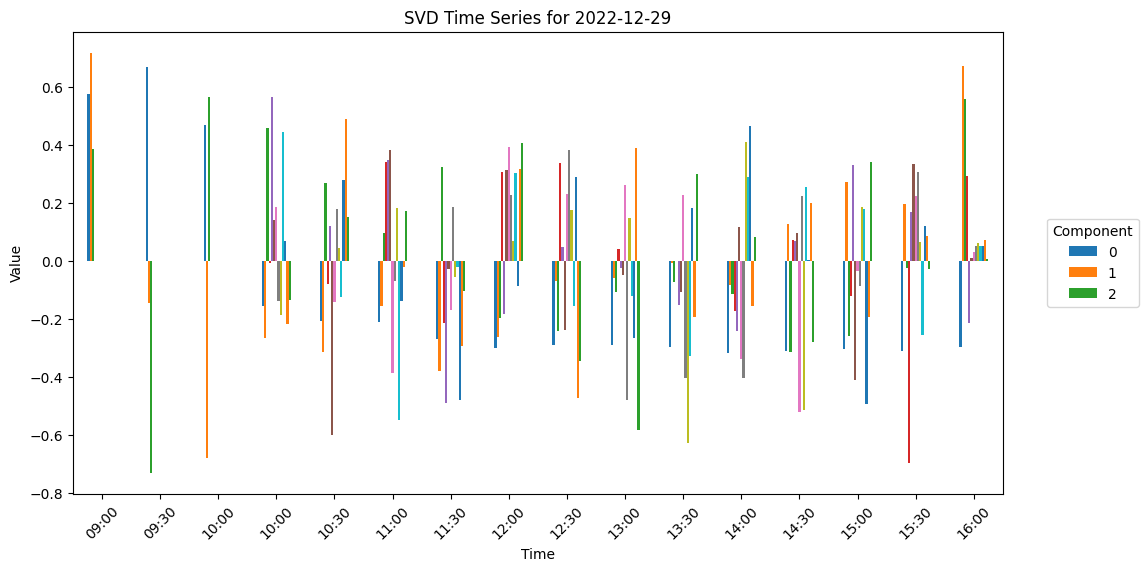

Skipping 2022-12-30 due to insufficient data
Skipping 2022-12-31 due to insufficient data
Skipping 2023-01-01 due to insufficient data
Skipping 2023-01-02 due to insufficient data
Skipping 2023-01-03 due to insufficient data
Skipping 2023-01-04 due to insufficient data
Skipping 2023-01-05 due to insufficient data
Skipping 2023-01-06 due to insufficient data
Skipping 2023-01-07 due to insufficient data
Skipping 2023-01-08 due to insufficient data
Skipping 2023-01-09 due to insufficient data
Skipping 2023-01-10 due to insufficient data


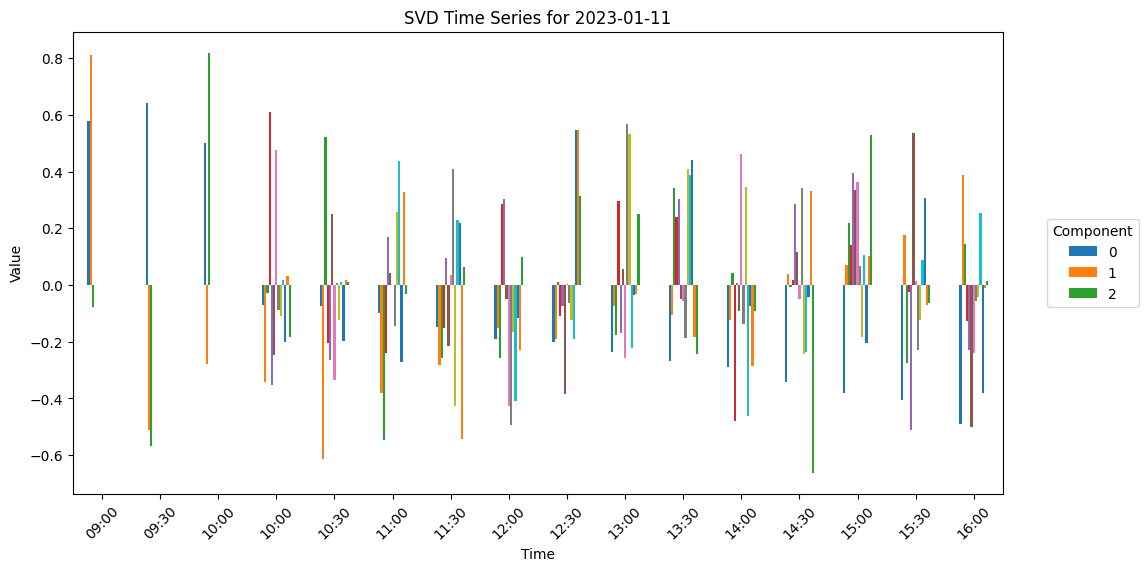

Skipping 2023-01-12 due to insufficient data


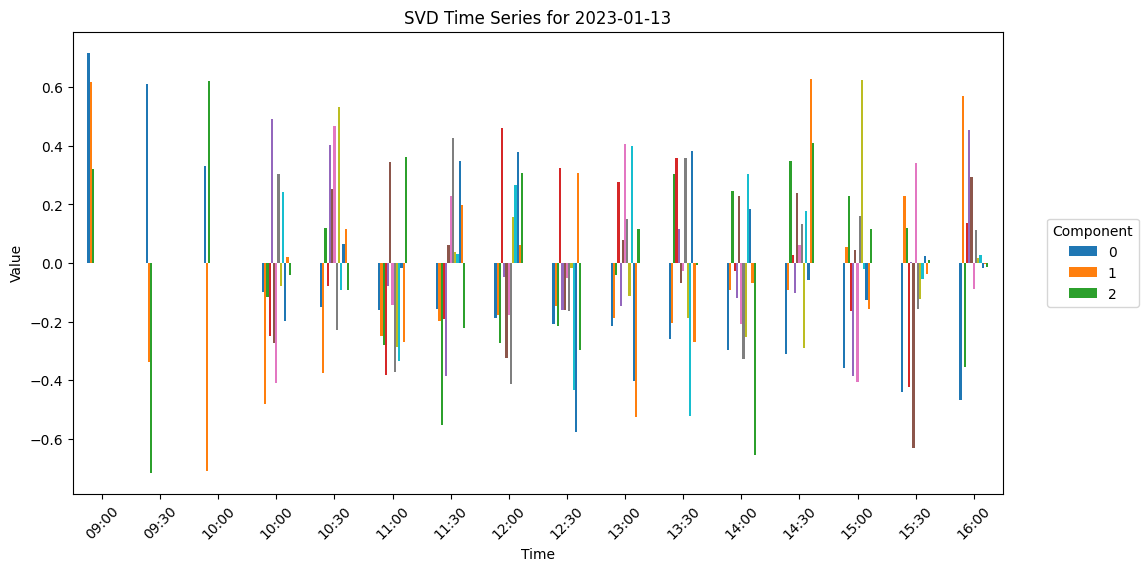

Skipping 2023-01-14 due to insufficient data
Skipping 2023-01-15 due to insufficient data
Skipping 2023-01-16 due to insufficient data
Skipping 2023-01-17 due to insufficient data
Skipping 2023-01-18 due to insufficient data
Skipping 2023-01-19 due to insufficient data


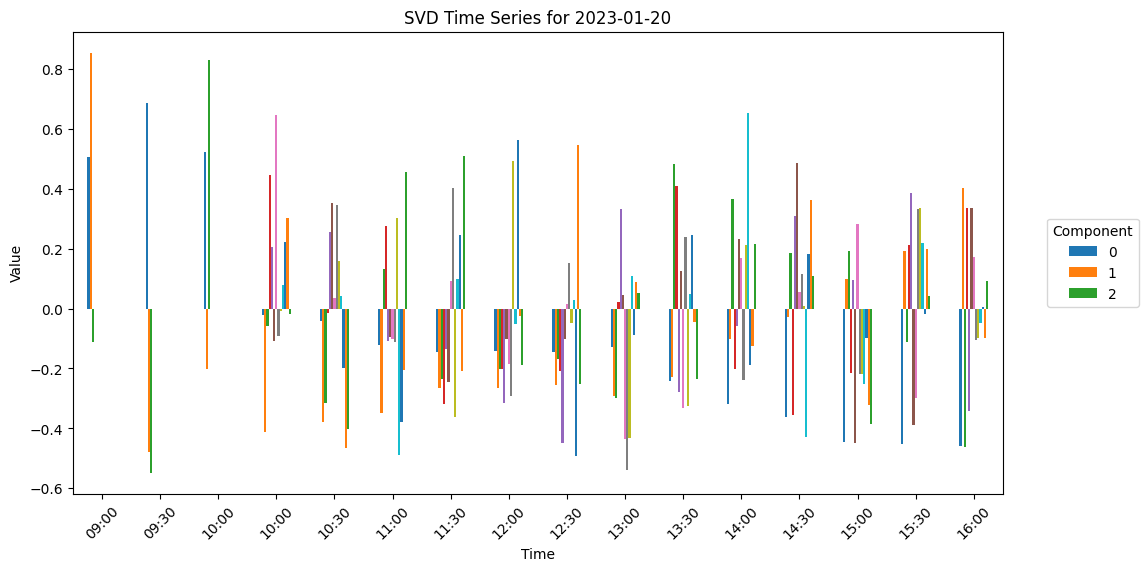

Skipping 2023-01-21 due to insufficient data
Skipping 2023-01-22 due to insufficient data


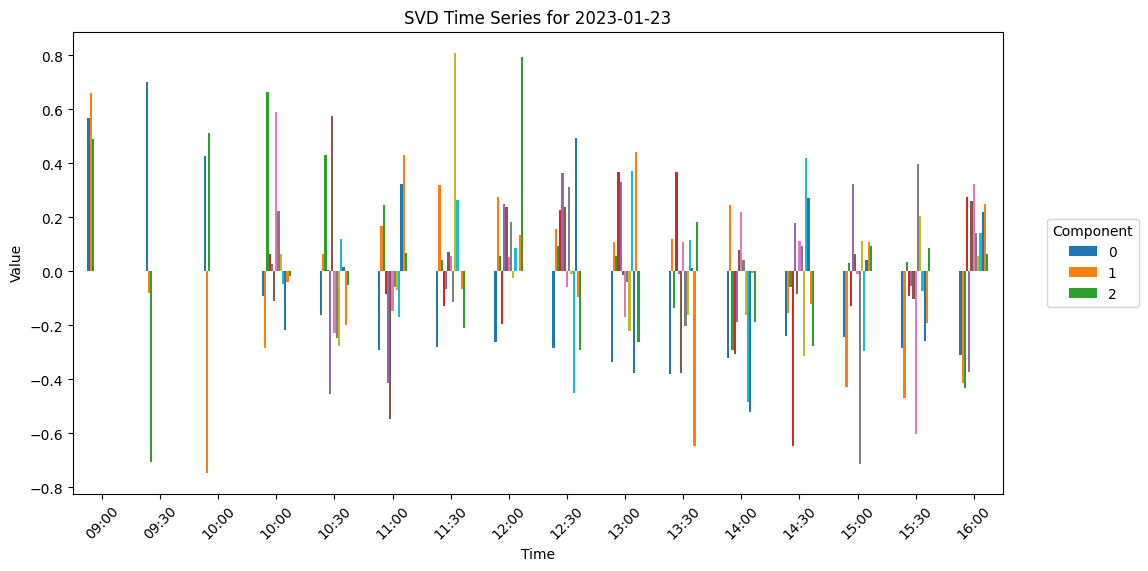

Skipping 2023-01-24 due to insufficient data
Skipping 2023-01-25 due to insufficient data
Skipping 2023-01-26 due to insufficient data
Skipping 2023-01-27 due to insufficient data
Skipping 2023-01-28 due to insufficient data
Skipping 2023-01-29 due to insufficient data
Skipping 2023-01-30 due to insufficient data


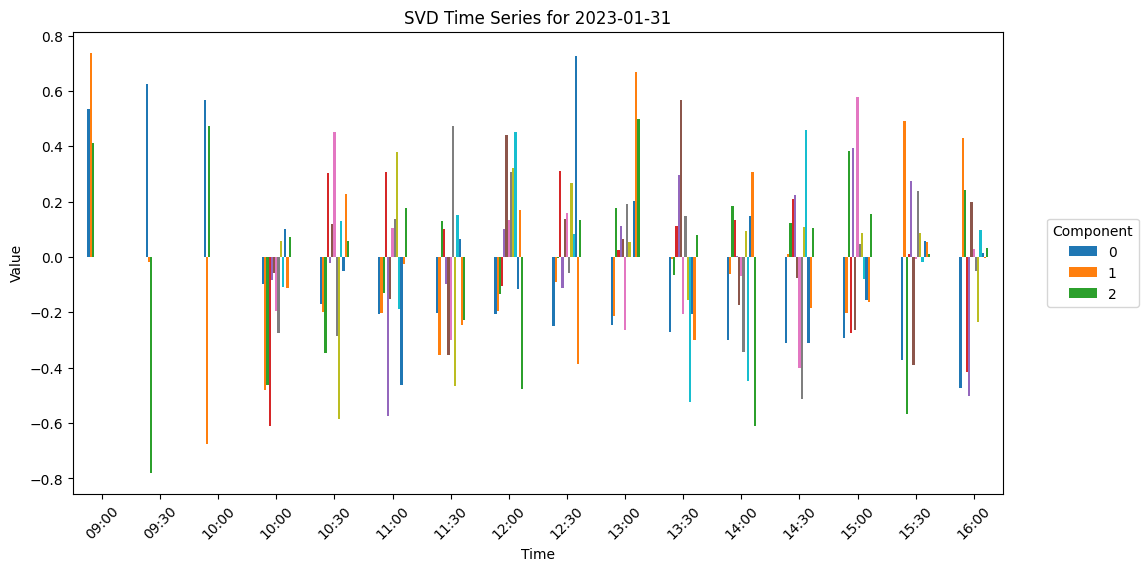

Skipping 2023-02-01 due to insufficient data
Skipping 2023-02-02 due to insufficient data
Skipping 2023-02-03 due to insufficient data
Skipping 2023-02-04 due to insufficient data
Skipping 2023-02-05 due to insufficient data
Skipping 2023-02-06 due to insufficient data
Skipping 2023-02-07 due to insufficient data
Skipping 2023-02-08 due to insufficient data
Skipping 2023-02-09 due to insufficient data
Skipping 2023-02-10 due to insufficient data
Skipping 2023-02-11 due to insufficient data
Skipping 2023-02-12 due to insufficient data


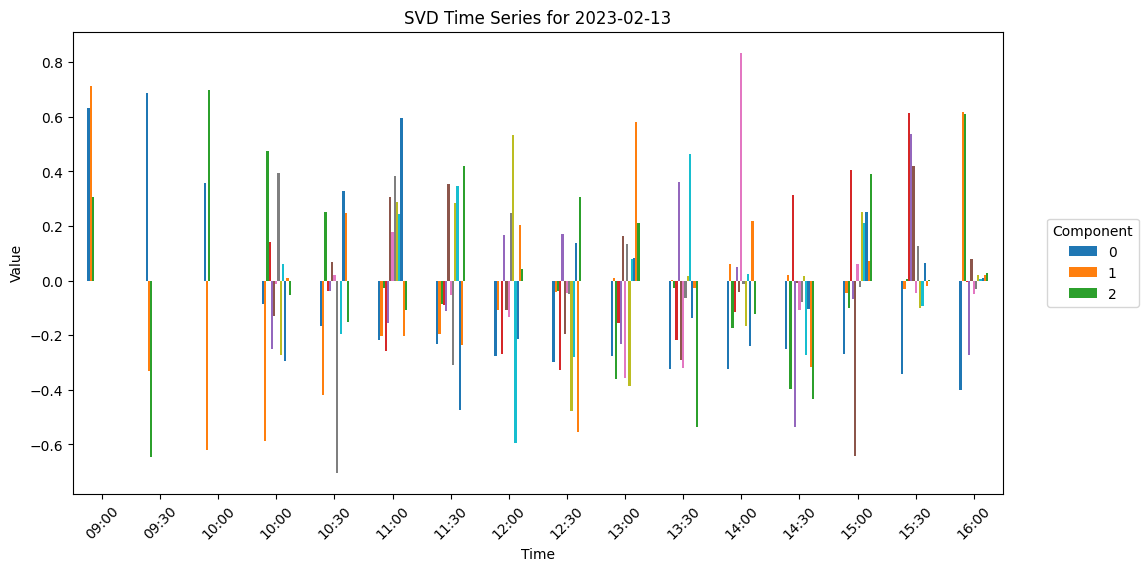

Skipping 2023-02-14 due to insufficient data
Skipping 2023-02-15 due to insufficient data
Skipping 2023-02-16 due to insufficient data
Skipping 2023-02-17 due to insufficient data
Skipping 2023-02-18 due to insufficient data
Skipping 2023-02-19 due to insufficient data
Skipping 2023-02-20 due to insufficient data
Skipping 2023-02-21 due to insufficient data
Skipping 2023-02-22 due to insufficient data
Skipping 2023-02-23 due to insufficient data
Skipping 2023-02-24 due to insufficient data
Skipping 2023-02-25 due to insufficient data
Skipping 2023-02-26 due to insufficient data
Skipping 2023-02-27 due to insufficient data
Skipping 2023-02-28 due to insufficient data
Skipping 2023-03-01 due to insufficient data


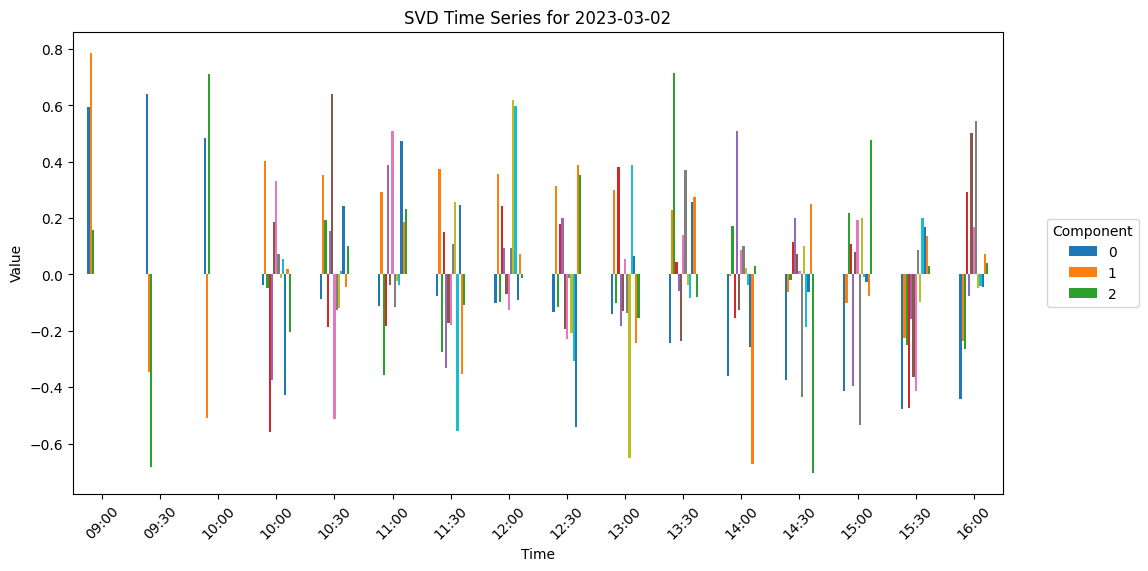

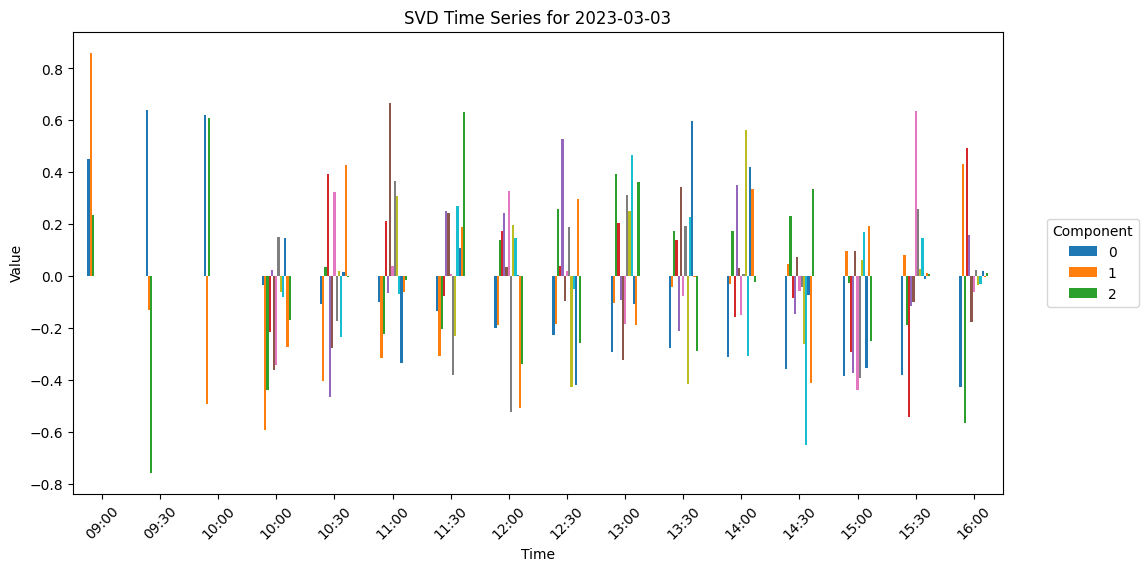

Skipping 2023-03-04 due to insufficient data
Skipping 2023-03-05 due to insufficient data
Skipping 2023-03-06 due to insufficient data
Skipping 2023-03-07 due to insufficient data
Skipping 2023-03-08 due to insufficient data
Skipping 2023-03-09 due to insufficient data
Skipping 2023-03-10 due to insufficient data
Skipping 2023-03-11 due to insufficient data
Skipping 2023-03-12 due to insufficient data
Skipping 2023-03-13 due to insufficient data
Skipping 2023-03-14 due to insufficient data
Skipping 2023-03-15 due to insufficient data


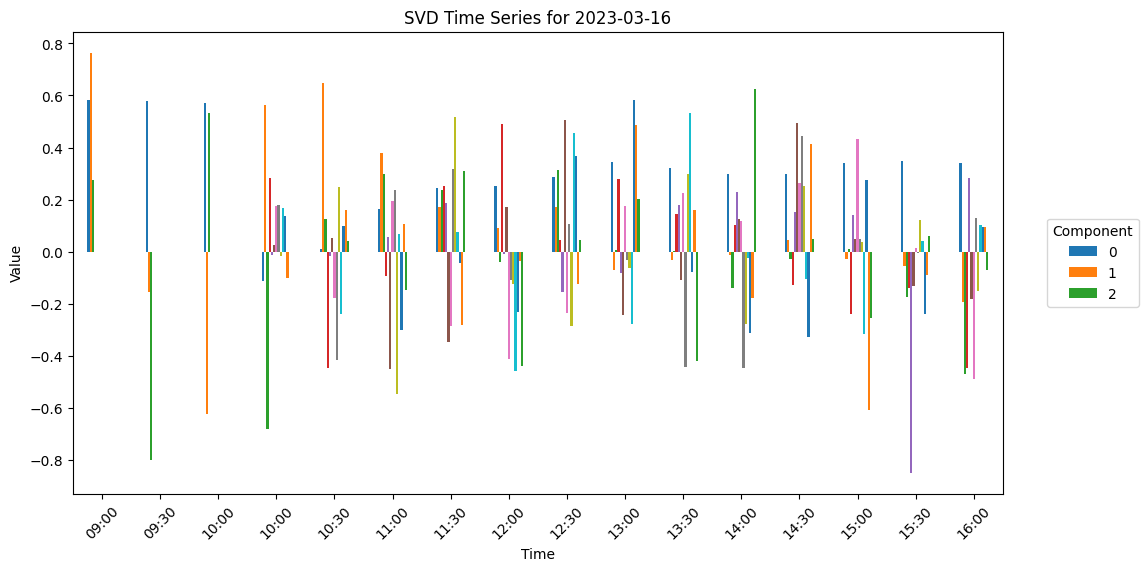

Skipping 2023-03-17 due to insufficient data
Skipping 2023-03-18 due to insufficient data
Skipping 2023-03-19 due to insufficient data
Skipping 2023-03-20 due to insufficient data
Skipping 2023-03-21 due to insufficient data
Skipping 2023-03-22 due to insufficient data
Skipping 2023-03-23 due to insufficient data


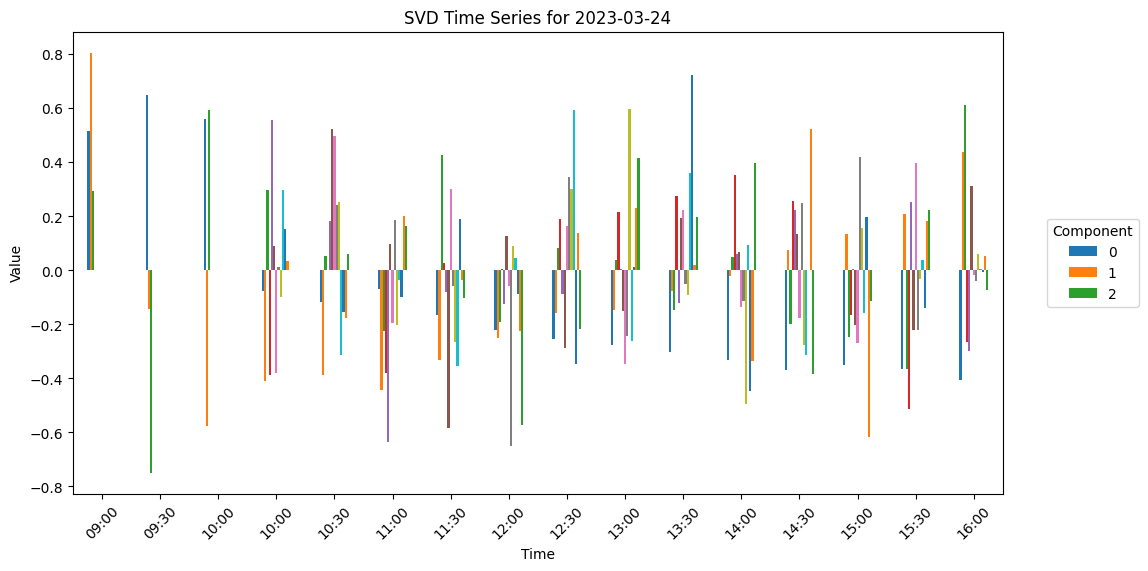

Skipping 2023-03-25 due to insufficient data
Skipping 2023-03-26 due to insufficient data
Skipping 2023-03-27 due to insufficient data
Skipping 2023-03-28 due to insufficient data
Skipping 2023-03-29 due to insufficient data
Skipping 2023-03-30 due to insufficient data


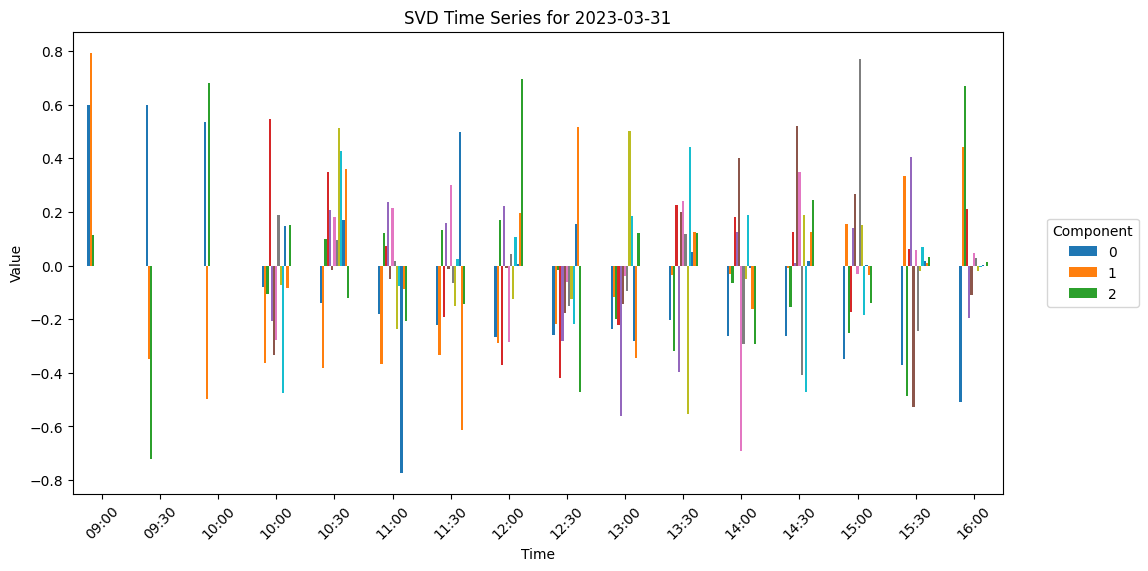

In [94]:
# from scipy.linalg import svd

def clean_data(df):
    # Replace infs with NaNs
    df = df.replace([np.inf, -np.inf], np.nan)
    # Drop rows with NaNs or fill them with appropriate values
    df = df.dropna()  # Or  df = df.fillna(some_value)
    return df

# Modify the perform_svd function to clean the data before performing SVD
# def perform_svd(window_data):
#     cleaned_data = clean_data(window_data)
#     U, s, Vt = svd(cleaned_data)
#     return pd.DataFrame(U, index= cleaned_data.index)


# Function to perform SVD on a given data window
def perform_svd(window_data):
    cleaned_data = clean_data(window_data)
    if cleaned_data.shape[0] < 2 or cleaned_data.shape[1] < 2:
        return None
    U, s, Vt = svd(cleaned_data)
    return pd.DataFrame(U, index=cleaned_data.index)

# Create your DataFrame here (I assume you already have one)
# nq_centered

# Resample the DataFrame into 30-minute intervals and group by day
resampled_df = nq_centered.resample('30T').mean()
grouped_df = resampled_df.groupby(resampled_df.index.date)


# Iterate over the groups
for day, group in grouped_df:
    # Filter the data between 9 am and 10 am, and 10 am and 4 pm
    hour_9_to_10 = group.between_time('09:00', '10:00')
    rest_of_hours = group.between_time('10:00', '16:00')

    # Perform SVD on both parts
    svd_9_to_10 = perform_svd(hour_9_to_10)
    svd_rest = perform_svd(rest_of_hours)

    # Check if the SVD results are valid
    valid_svd = svd_9_to_10 is not None and svd_rest is not None

    if valid_svd:
        # Combine the SVD results
        combined_svd = pd.concat([svd_9_to_10, svd_rest], axis=0)

        # Plot the combined SVD result as a bar plot
        combined_svd.plot(kind='bar', figsize=(12, 6))
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"SVD Time Series for {day}")
        plt.legend(svd_9_to_10.columns, title="Component", bbox_to_anchor=(1.04, 0.5), loc="center left")
        plt.xticks(range(len(combined_svd.index)), [t.strftime('%H:%M') for t in combined_svd.index.time], rotation=45)
        plt.show()
    else:
        print(f"Skipping {day} due to insufficient data")


In [101]:

nq_centered.drop('typeD', axis=1, inplace=True)


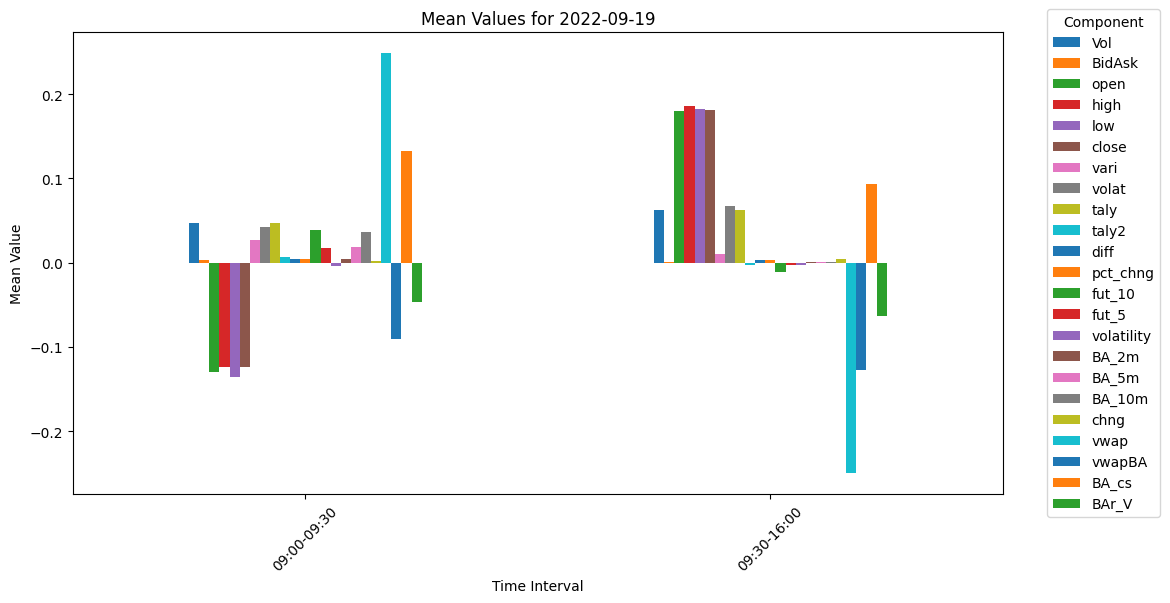

Skipping 2022-09-20 due to insufficient data
Skipping 2022-09-21 due to insufficient data
Skipping 2022-09-22 due to insufficient data
Skipping 2022-09-23 due to insufficient data
Skipping 2022-09-24 due to insufficient data
Skipping 2022-09-25 due to insufficient data
Skipping 2022-09-26 due to insufficient data
Skipping 2022-09-27 due to insufficient data


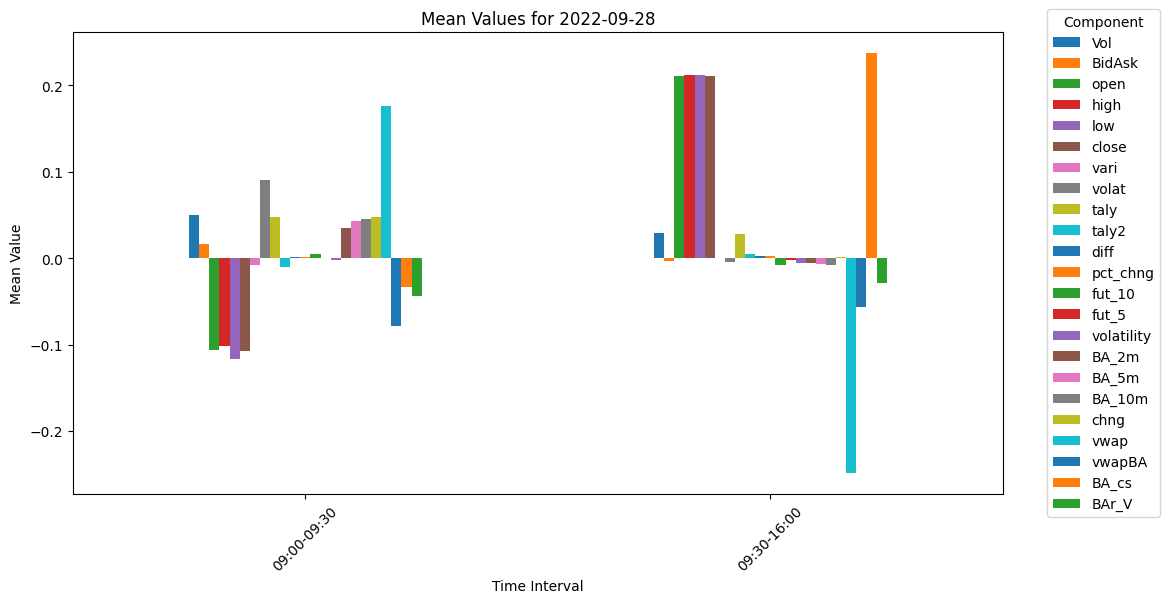

Skipping 2022-09-29 due to insufficient data
Skipping 2022-09-30 due to insufficient data
Skipping 2022-10-01 due to insufficient data
Skipping 2022-10-02 due to insufficient data


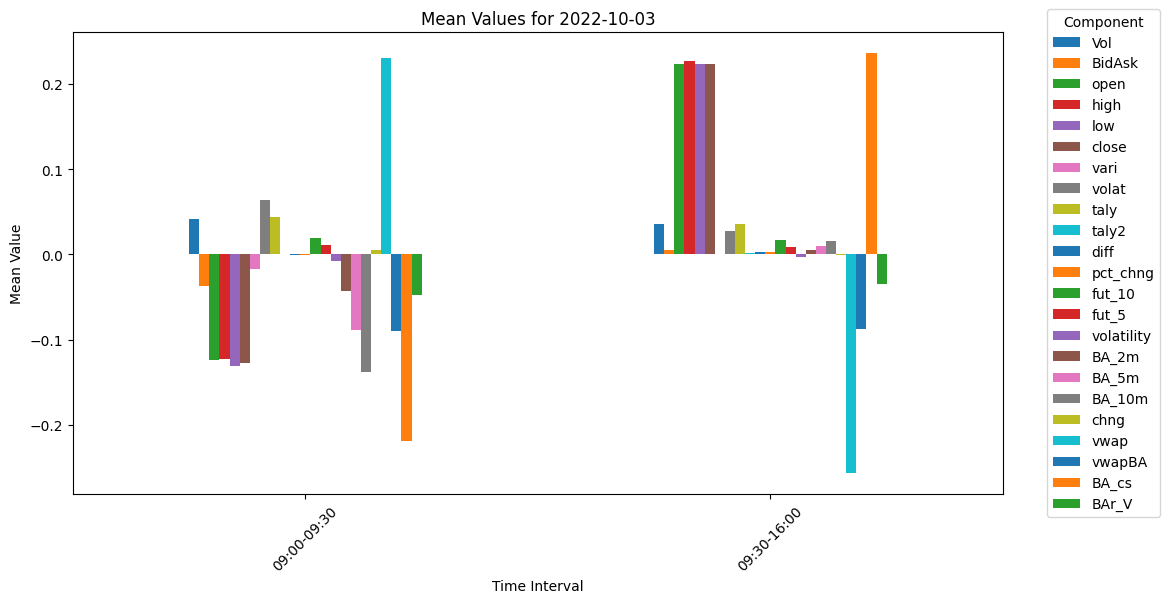

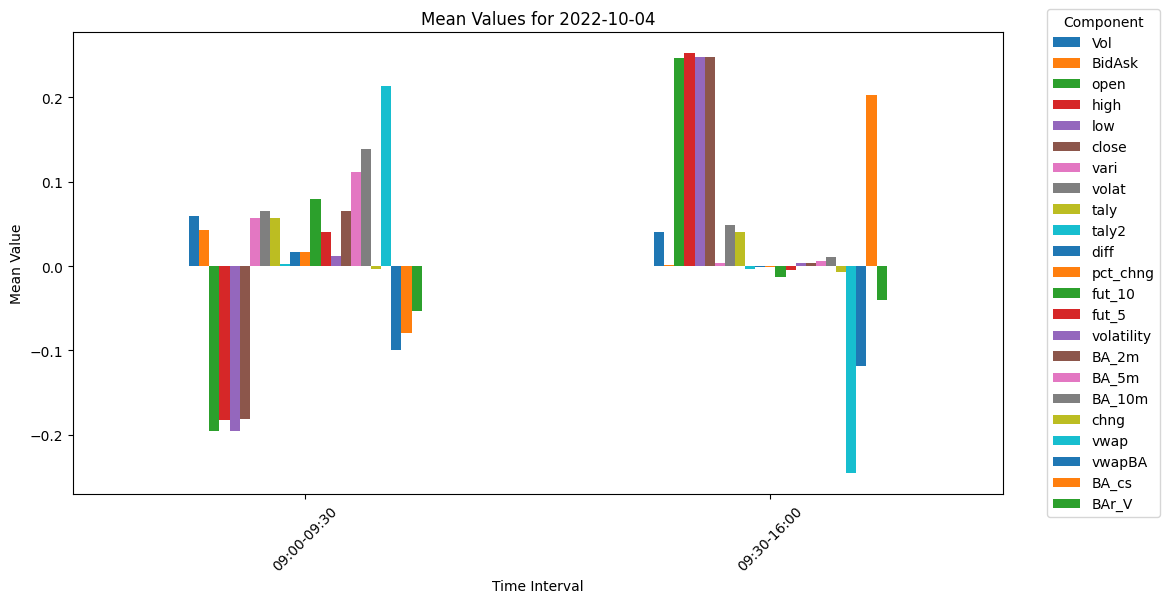

Skipping 2022-10-05 due to insufficient data
Skipping 2022-10-06 due to insufficient data
Skipping 2022-10-07 due to insufficient data
Skipping 2022-10-08 due to insufficient data
Skipping 2022-10-09 due to insufficient data
Skipping 2022-10-10 due to insufficient data
Skipping 2022-10-11 due to insufficient data
Skipping 2022-10-12 due to insufficient data


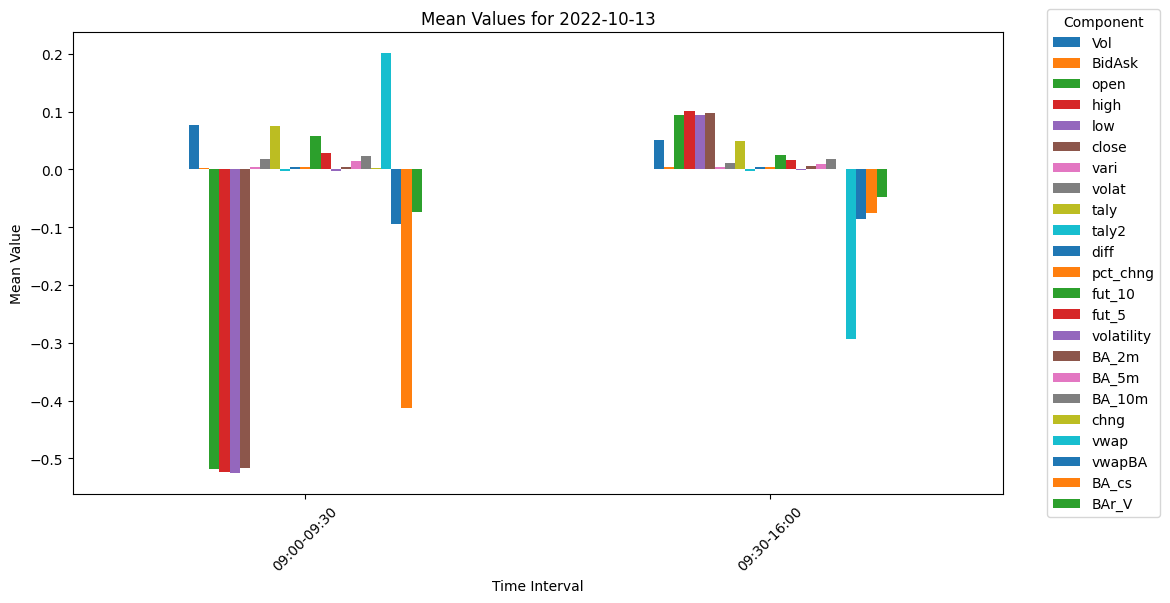

Skipping 2022-10-14 due to insufficient data
Skipping 2022-10-15 due to insufficient data
Skipping 2022-10-16 due to insufficient data


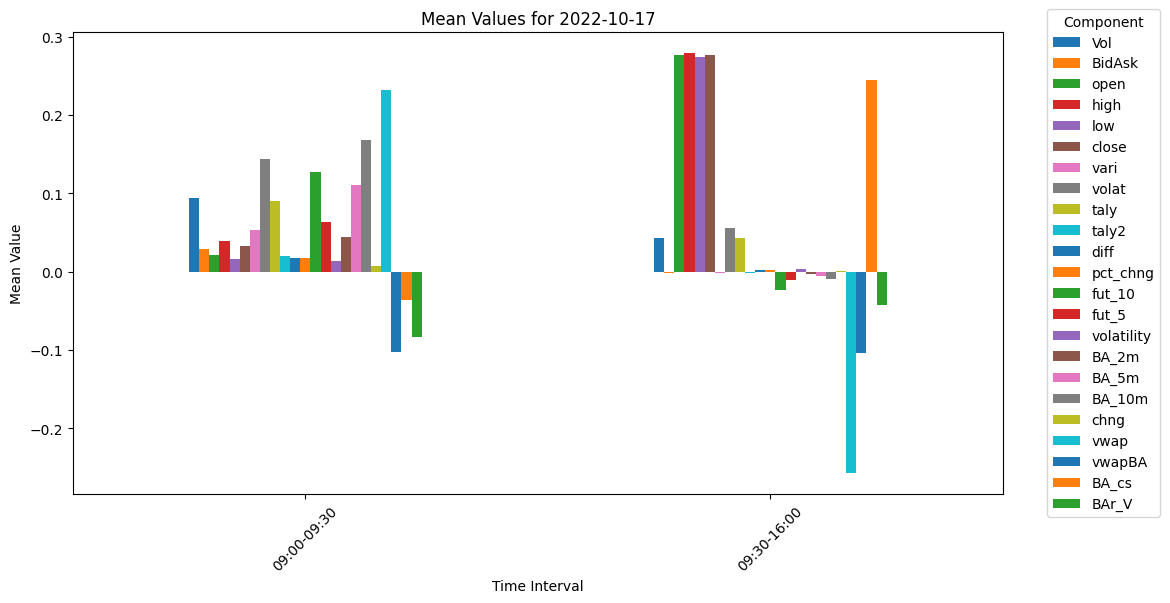

Skipping 2022-10-18 due to insufficient data
Skipping 2022-10-19 due to insufficient data
Skipping 2022-10-20 due to insufficient data


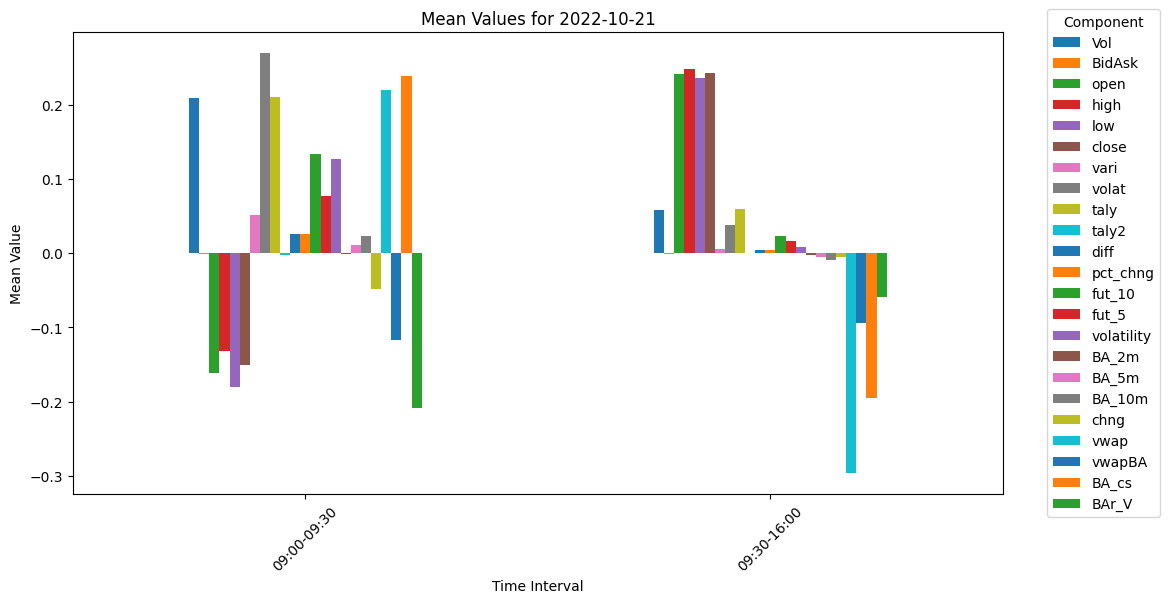

Skipping 2022-10-22 due to insufficient data
Skipping 2022-10-23 due to insufficient data
Skipping 2022-10-24 due to insufficient data


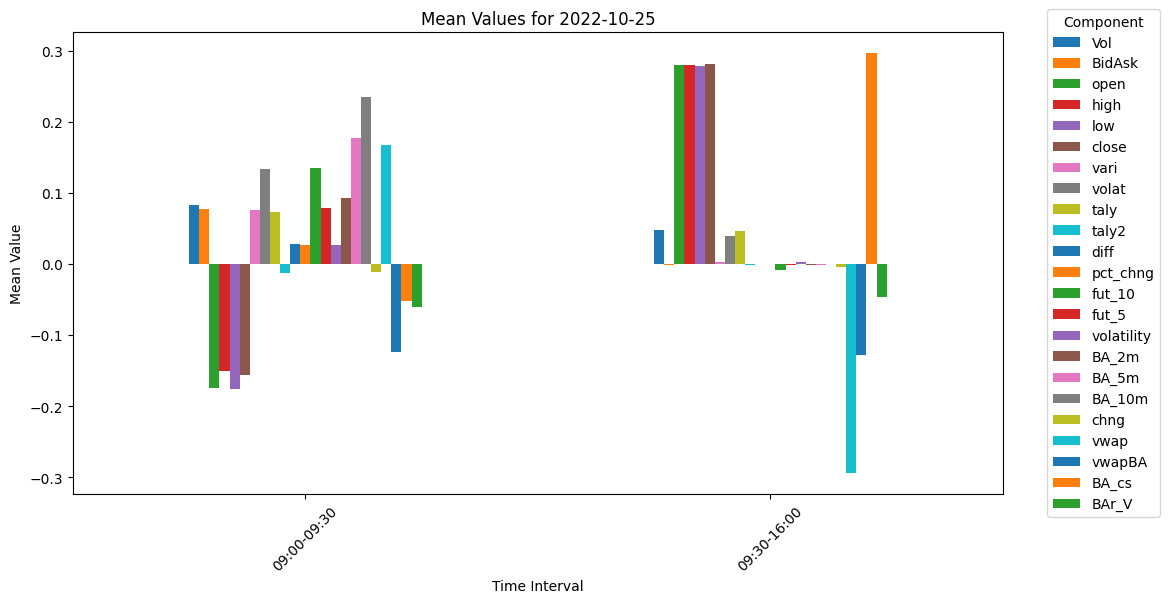

Skipping 2022-10-26 due to insufficient data
Skipping 2022-10-27 due to insufficient data


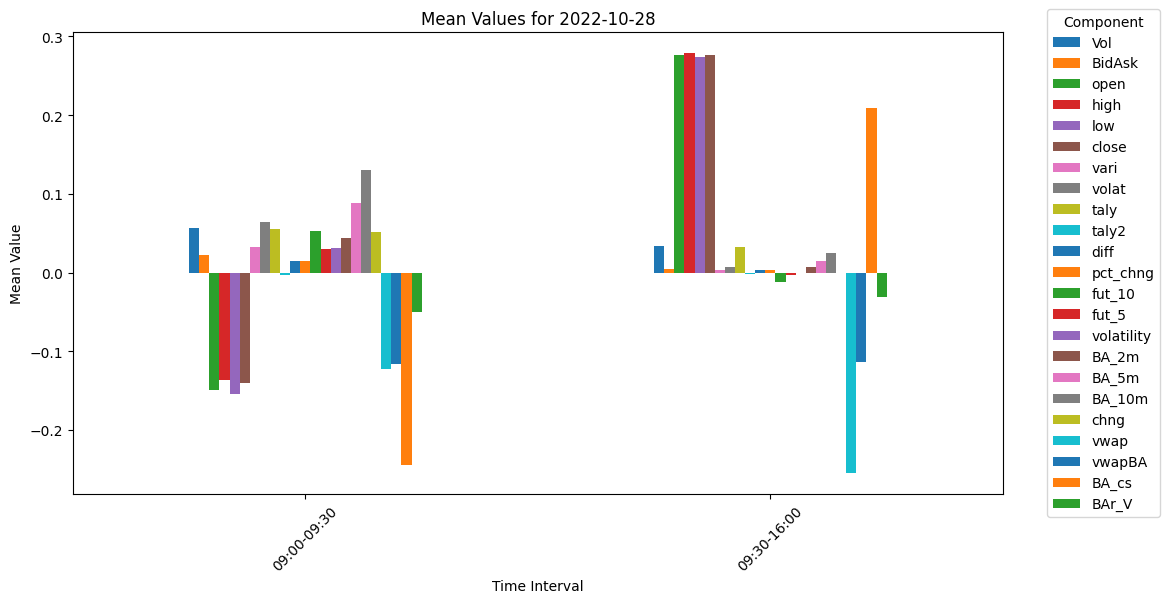

Skipping 2022-10-29 due to insufficient data
Skipping 2022-10-30 due to insufficient data
Skipping 2022-10-31 due to insufficient data
Skipping 2022-11-01 due to insufficient data
Skipping 2022-11-02 due to insufficient data
Skipping 2022-11-03 due to insufficient data
Skipping 2022-11-04 due to insufficient data
Skipping 2022-11-05 due to insufficient data
Skipping 2022-11-06 due to insufficient data
Skipping 2022-11-07 due to insufficient data
Skipping 2022-11-08 due to insufficient data
Skipping 2022-11-09 due to insufficient data


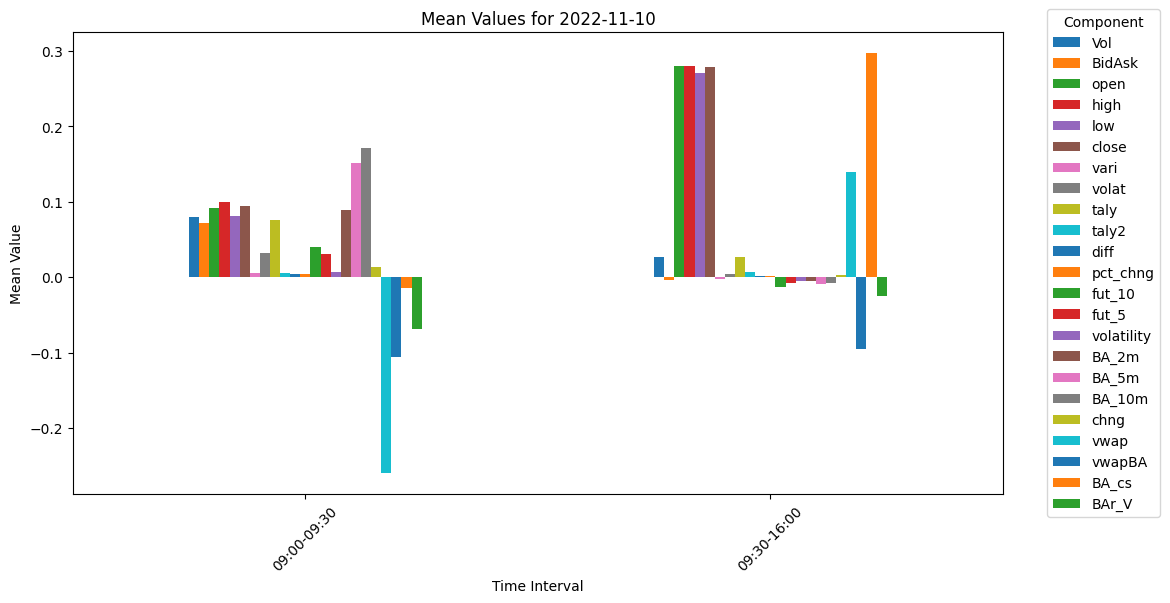

Skipping 2022-11-11 due to insufficient data
Skipping 2022-11-12 due to insufficient data
Skipping 2022-11-13 due to insufficient data
Skipping 2022-11-14 due to insufficient data
Skipping 2022-11-15 due to insufficient data
Skipping 2022-11-16 due to insufficient data
Skipping 2022-11-17 due to insufficient data
Skipping 2022-11-18 due to insufficient data
Skipping 2022-11-19 due to insufficient data
Skipping 2022-11-20 due to insufficient data
Skipping 2022-11-21 due to insufficient data


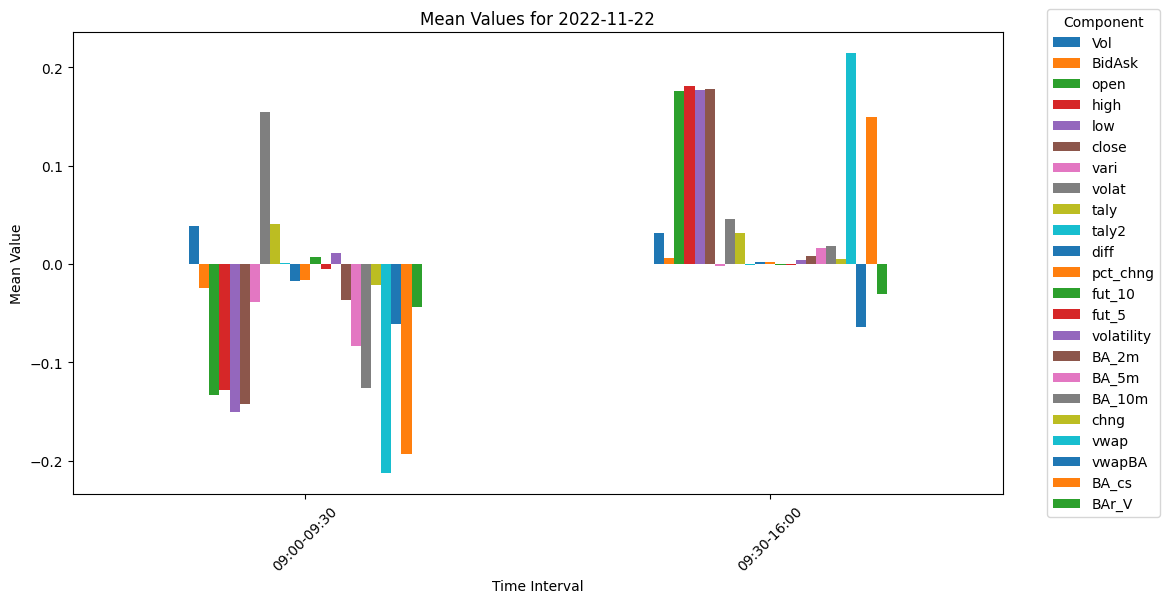

Skipping 2022-11-23 due to insufficient data
Skipping 2022-11-24 due to insufficient data
Skipping 2022-11-25 due to insufficient data
Skipping 2022-11-26 due to insufficient data
Skipping 2022-11-27 due to insufficient data
Skipping 2022-11-28 due to insufficient data
Skipping 2022-11-29 due to insufficient data


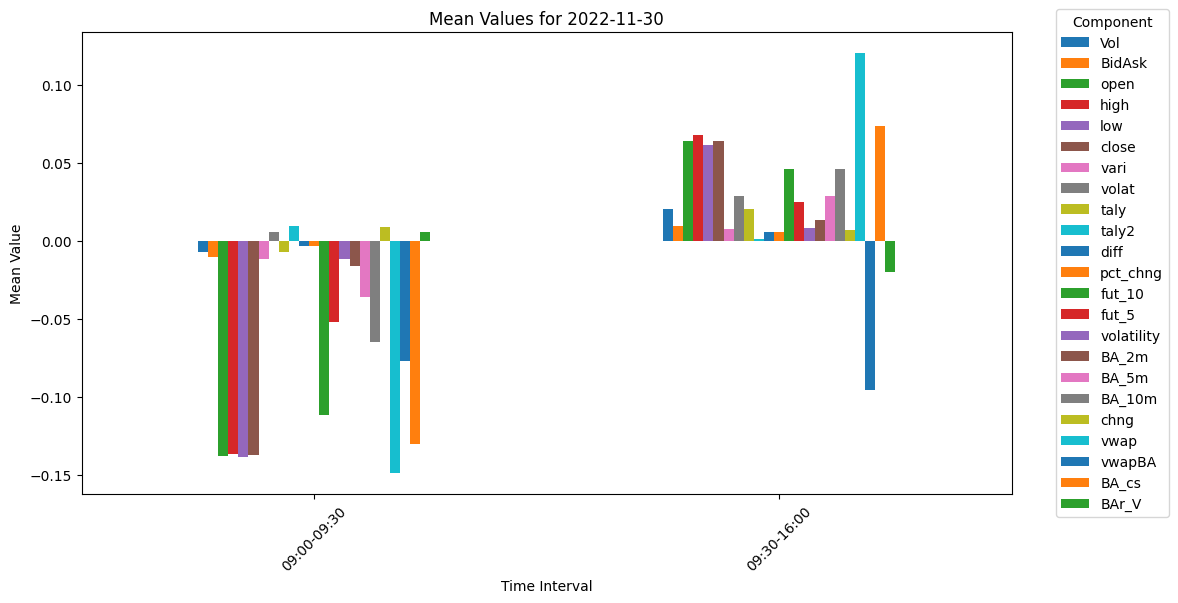

Skipping 2022-12-01 due to insufficient data


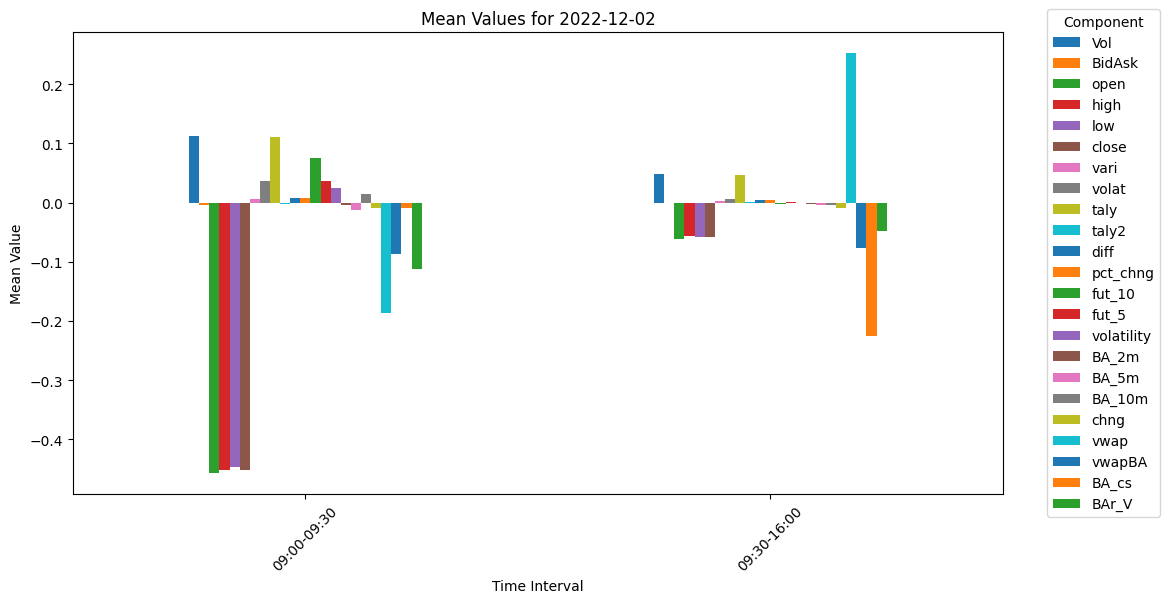

Skipping 2022-12-03 due to insufficient data
Skipping 2022-12-04 due to insufficient data
Skipping 2022-12-05 due to insufficient data
Skipping 2022-12-06 due to insufficient data
Skipping 2022-12-07 due to insufficient data
Skipping 2022-12-08 due to insufficient data
Skipping 2022-12-09 due to insufficient data
Skipping 2022-12-10 due to insufficient data
Skipping 2022-12-11 due to insufficient data


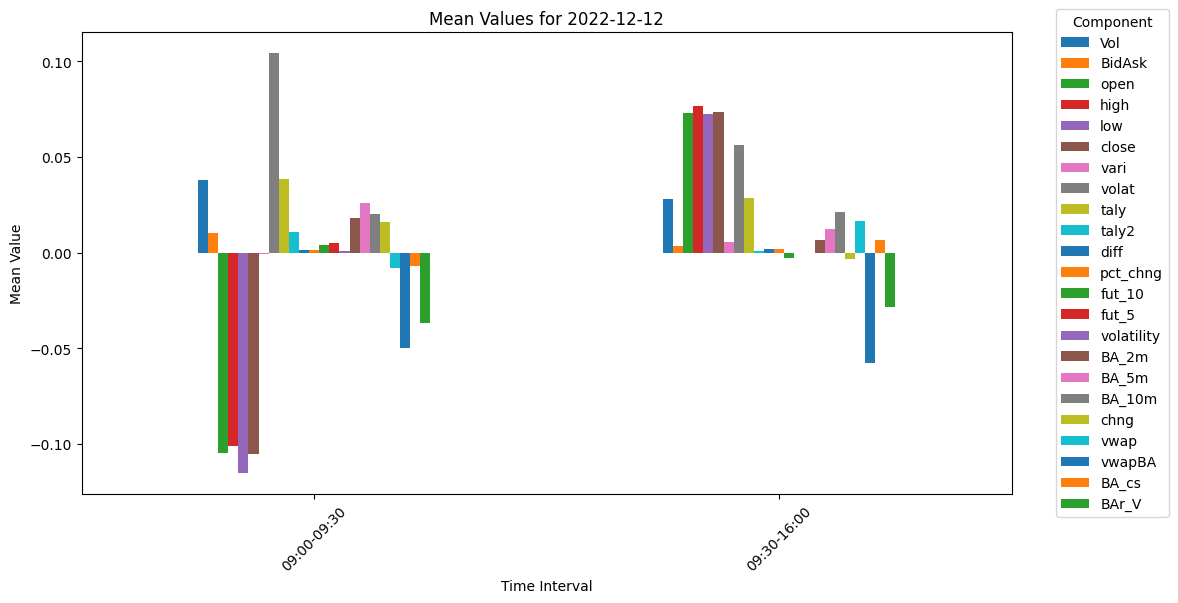

Skipping 2022-12-13 due to insufficient data
Skipping 2022-12-14 due to insufficient data
Skipping 2022-12-15 due to insufficient data
Skipping 2022-12-16 due to insufficient data
Skipping 2022-12-17 due to insufficient data
Skipping 2022-12-18 due to insufficient data
Skipping 2022-12-19 due to insufficient data
Skipping 2022-12-20 due to insufficient data


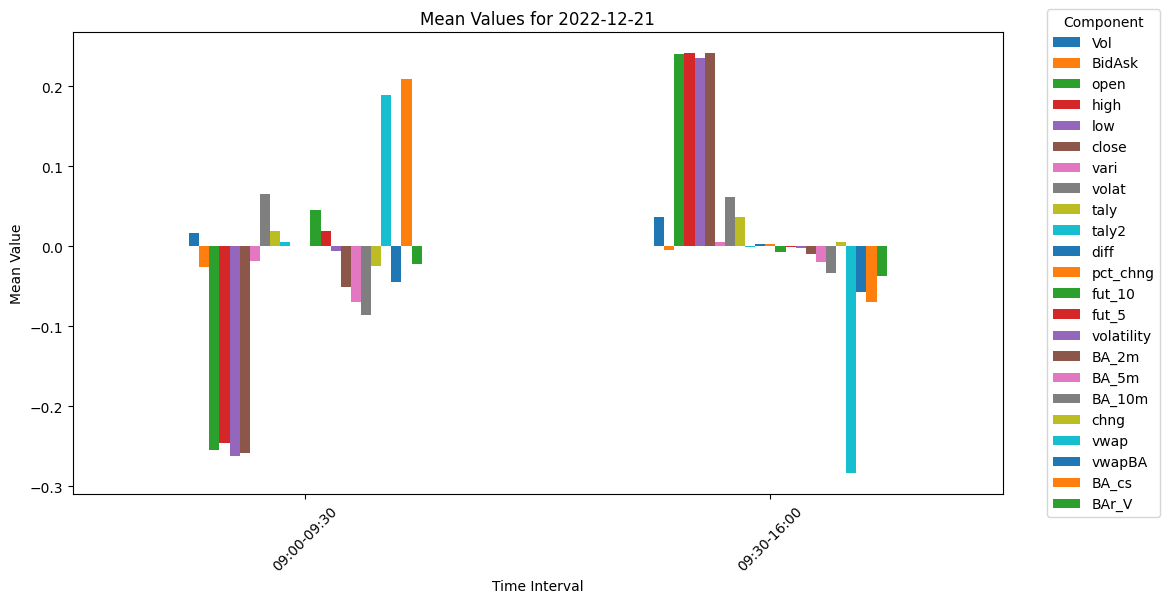

Skipping 2022-12-22 due to insufficient data
Skipping 2022-12-23 due to insufficient data
Skipping 2022-12-24 due to insufficient data
Skipping 2022-12-25 due to insufficient data
Skipping 2022-12-26 due to insufficient data
Skipping 2022-12-27 due to insufficient data
Skipping 2022-12-28 due to insufficient data


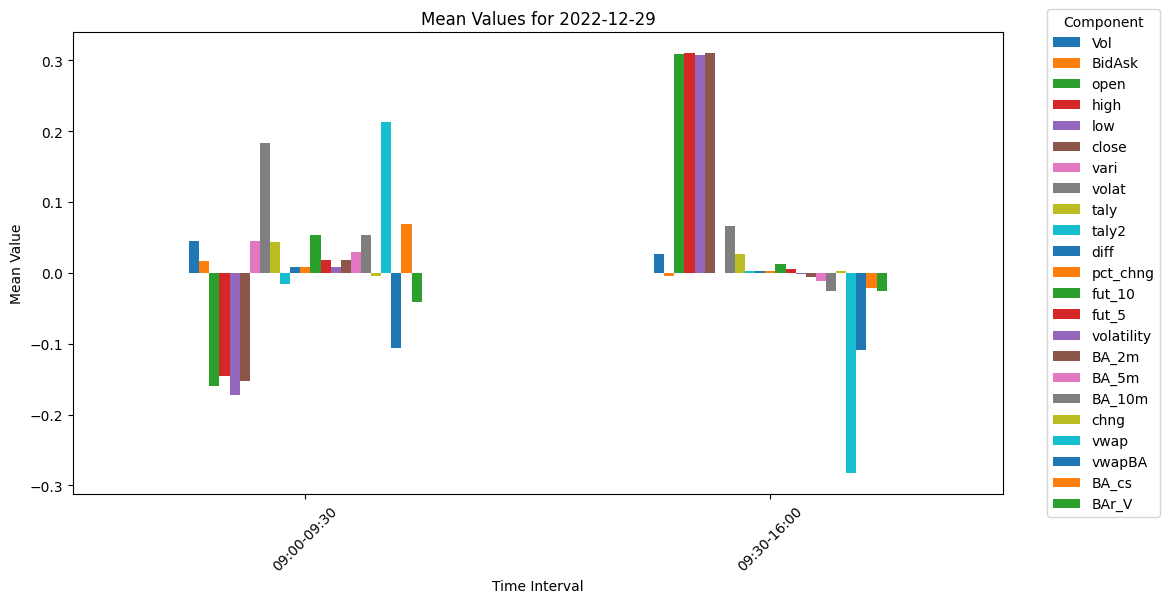

Skipping 2022-12-30 due to insufficient data
Skipping 2022-12-31 due to insufficient data
Skipping 2023-01-01 due to insufficient data
Skipping 2023-01-02 due to insufficient data
Skipping 2023-01-03 due to insufficient data
Skipping 2023-01-04 due to insufficient data
Skipping 2023-01-05 due to insufficient data
Skipping 2023-01-06 due to insufficient data
Skipping 2023-01-07 due to insufficient data
Skipping 2023-01-08 due to insufficient data
Skipping 2023-01-09 due to insufficient data
Skipping 2023-01-10 due to insufficient data


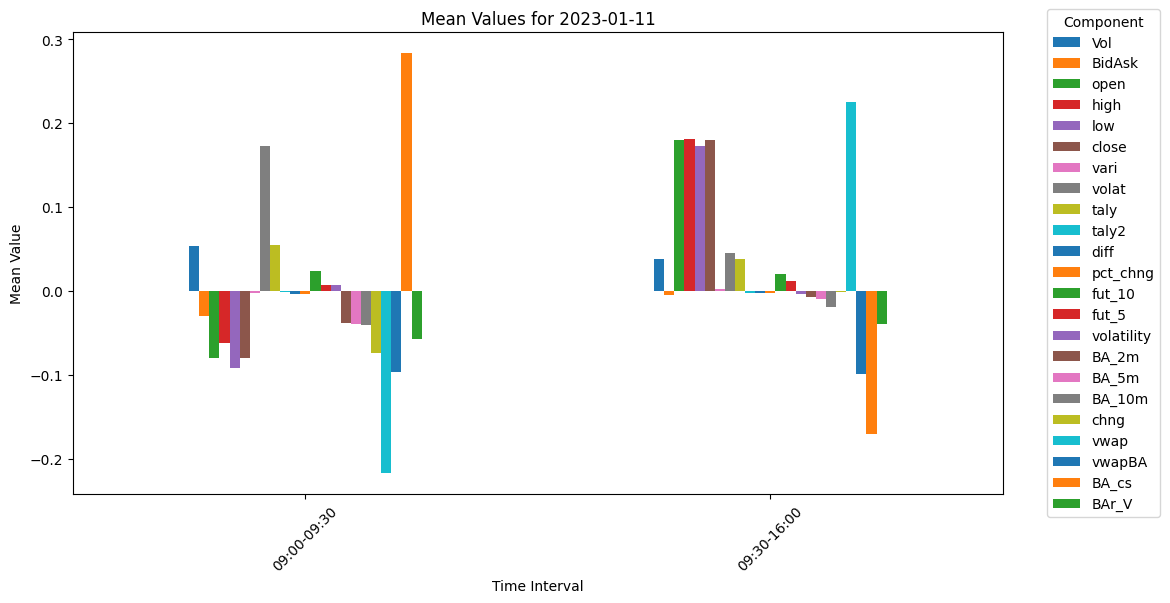

Skipping 2023-01-12 due to insufficient data


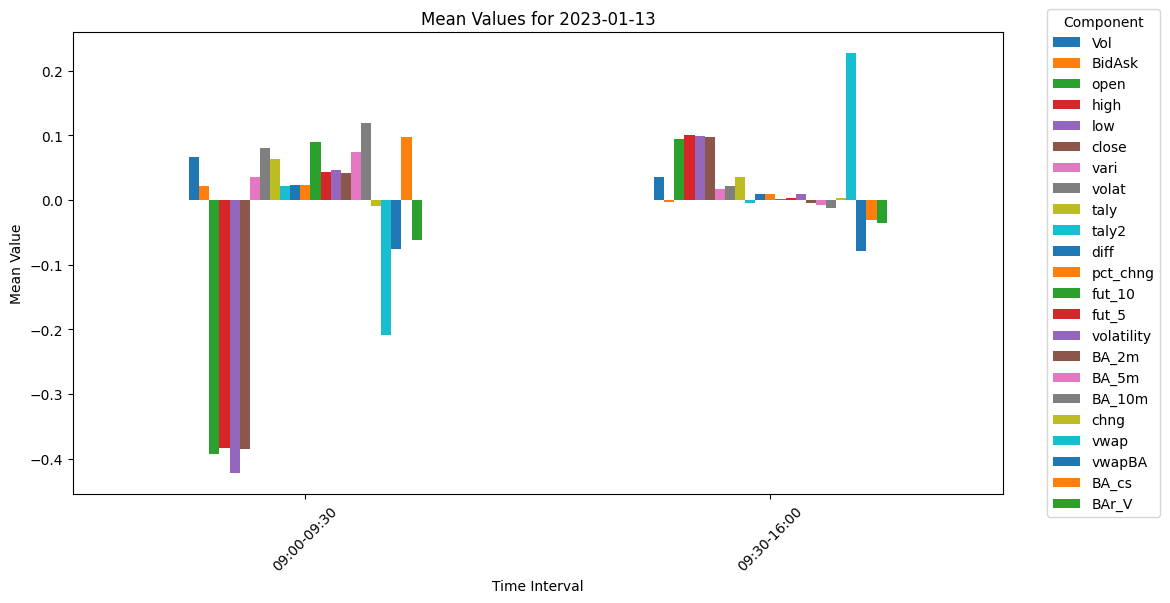

Skipping 2023-01-14 due to insufficient data
Skipping 2023-01-15 due to insufficient data
Skipping 2023-01-16 due to insufficient data
Skipping 2023-01-17 due to insufficient data
Skipping 2023-01-18 due to insufficient data
Skipping 2023-01-19 due to insufficient data


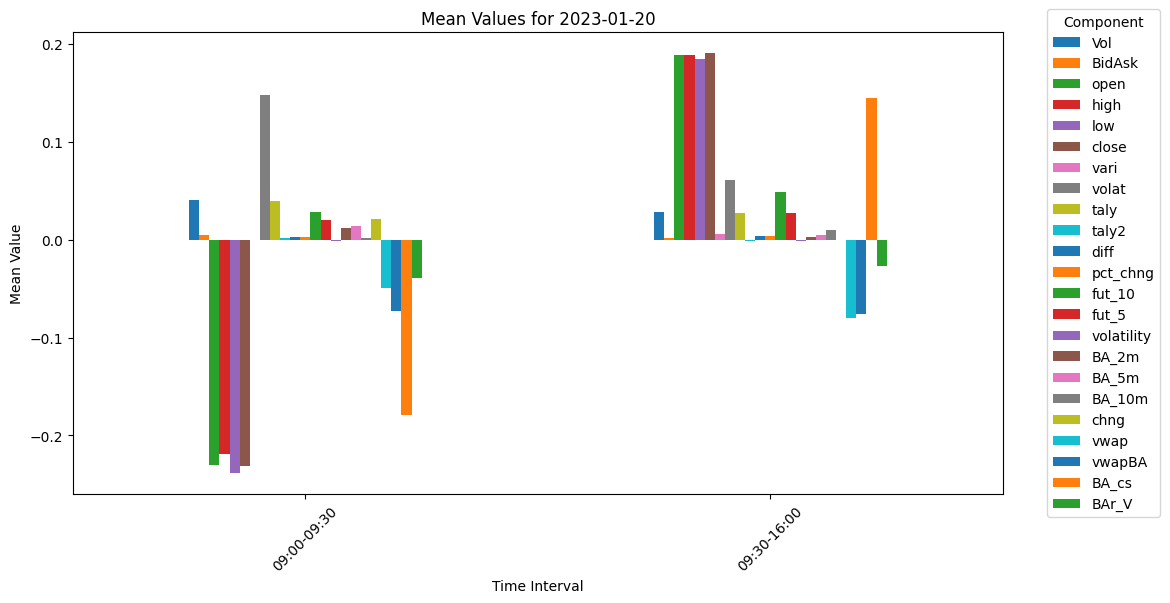

Skipping 2023-01-21 due to insufficient data
Skipping 2023-01-22 due to insufficient data


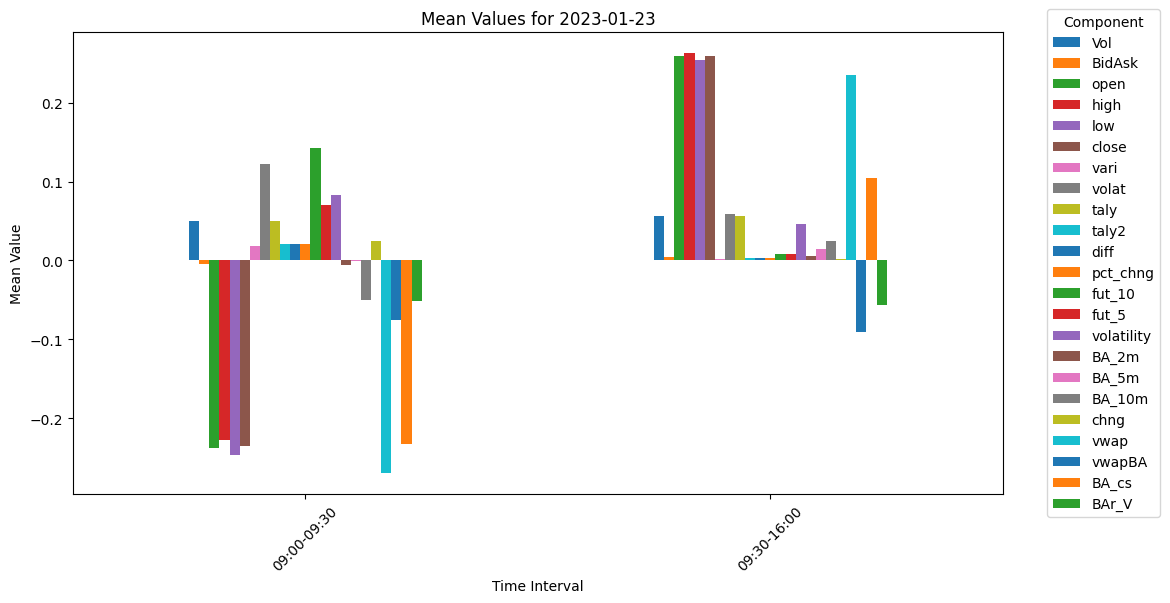

Skipping 2023-01-24 due to insufficient data
Skipping 2023-01-25 due to insufficient data
Skipping 2023-01-26 due to insufficient data
Skipping 2023-01-27 due to insufficient data
Skipping 2023-01-28 due to insufficient data
Skipping 2023-01-29 due to insufficient data
Skipping 2023-01-30 due to insufficient data


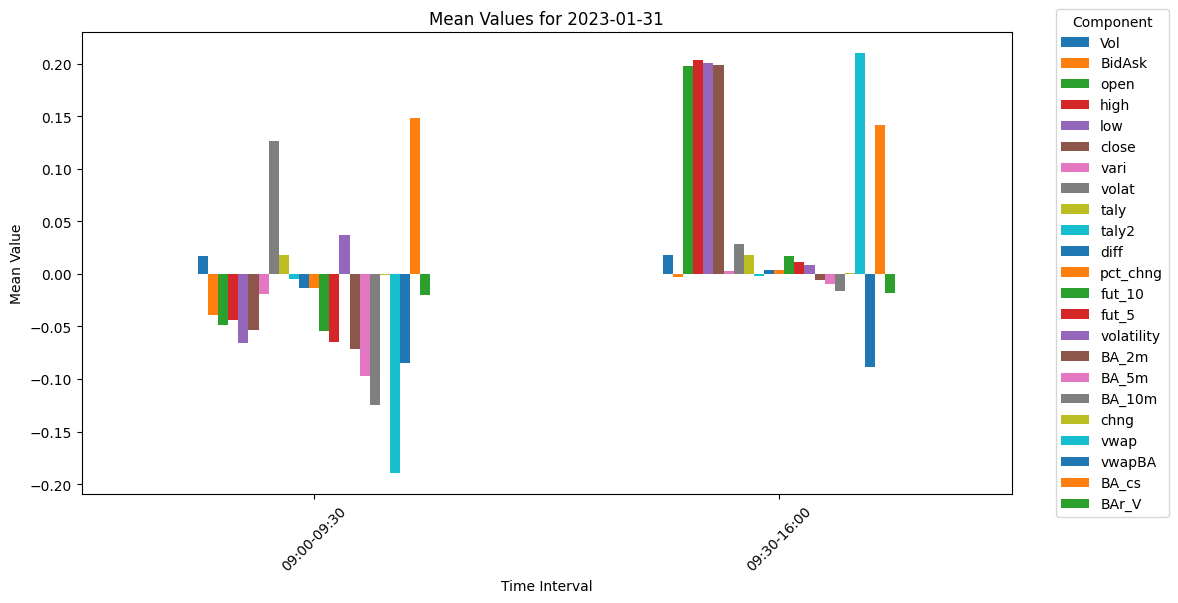

Skipping 2023-02-01 due to insufficient data
Skipping 2023-02-02 due to insufficient data
Skipping 2023-02-03 due to insufficient data
Skipping 2023-02-04 due to insufficient data
Skipping 2023-02-05 due to insufficient data
Skipping 2023-02-06 due to insufficient data
Skipping 2023-02-07 due to insufficient data
Skipping 2023-02-08 due to insufficient data
Skipping 2023-02-09 due to insufficient data
Skipping 2023-02-10 due to insufficient data
Skipping 2023-02-11 due to insufficient data
Skipping 2023-02-12 due to insufficient data


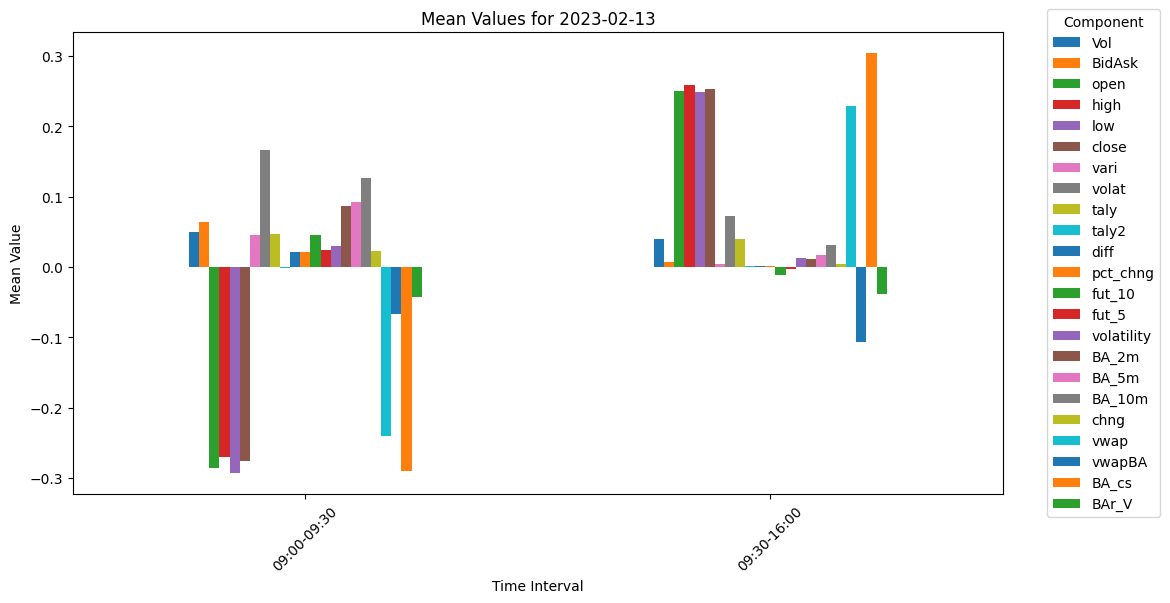

Skipping 2023-02-14 due to insufficient data
Skipping 2023-02-15 due to insufficient data
Skipping 2023-02-16 due to insufficient data
Skipping 2023-02-17 due to insufficient data
Skipping 2023-02-18 due to insufficient data
Skipping 2023-02-19 due to insufficient data
Skipping 2023-02-20 due to insufficient data
Skipping 2023-02-21 due to insufficient data
Skipping 2023-02-22 due to insufficient data
Skipping 2023-02-23 due to insufficient data
Skipping 2023-02-24 due to insufficient data
Skipping 2023-02-25 due to insufficient data
Skipping 2023-02-26 due to insufficient data
Skipping 2023-02-27 due to insufficient data
Skipping 2023-02-28 due to insufficient data
Skipping 2023-03-01 due to insufficient data


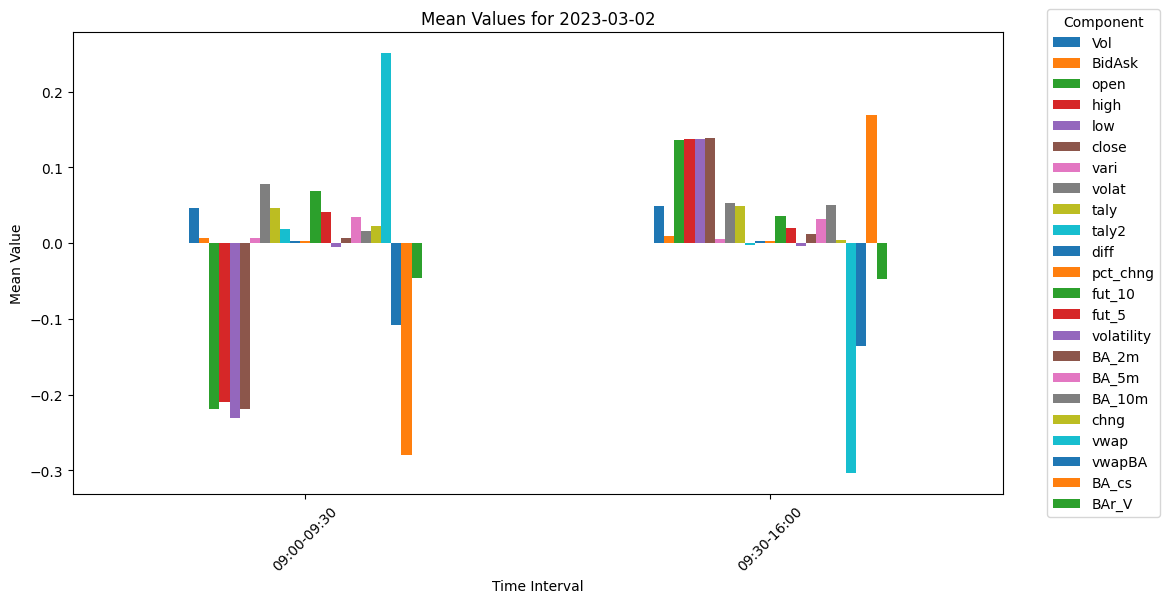

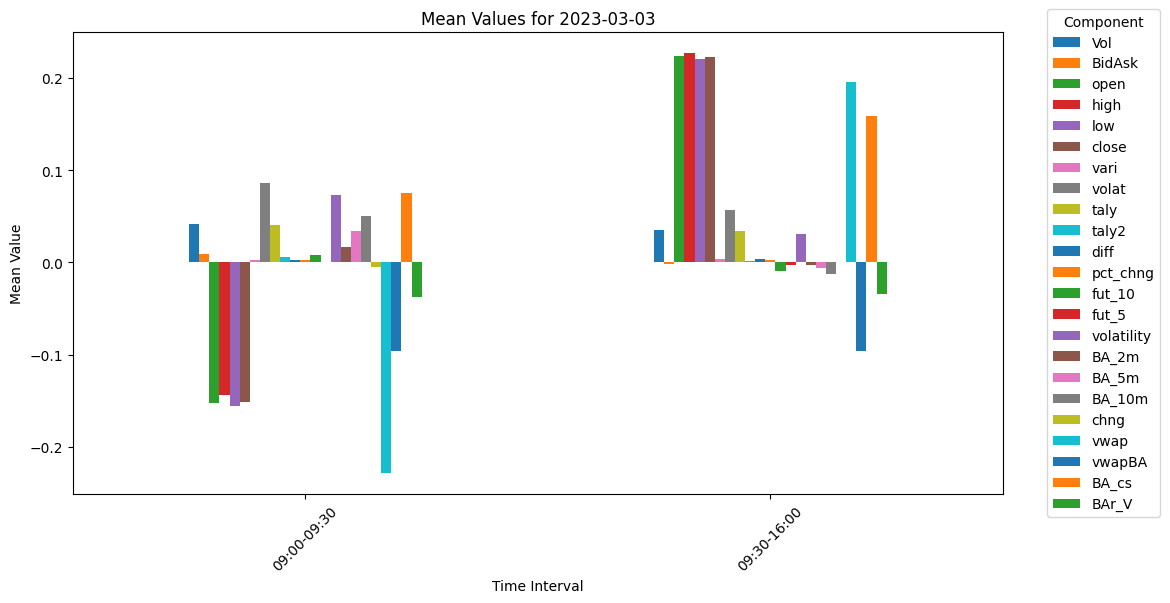

Skipping 2023-03-04 due to insufficient data
Skipping 2023-03-05 due to insufficient data
Skipping 2023-03-06 due to insufficient data
Skipping 2023-03-07 due to insufficient data
Skipping 2023-03-08 due to insufficient data
Skipping 2023-03-09 due to insufficient data
Skipping 2023-03-10 due to insufficient data
Skipping 2023-03-11 due to insufficient data
Skipping 2023-03-12 due to insufficient data
Skipping 2023-03-13 due to insufficient data
Skipping 2023-03-14 due to insufficient data
Skipping 2023-03-15 due to insufficient data


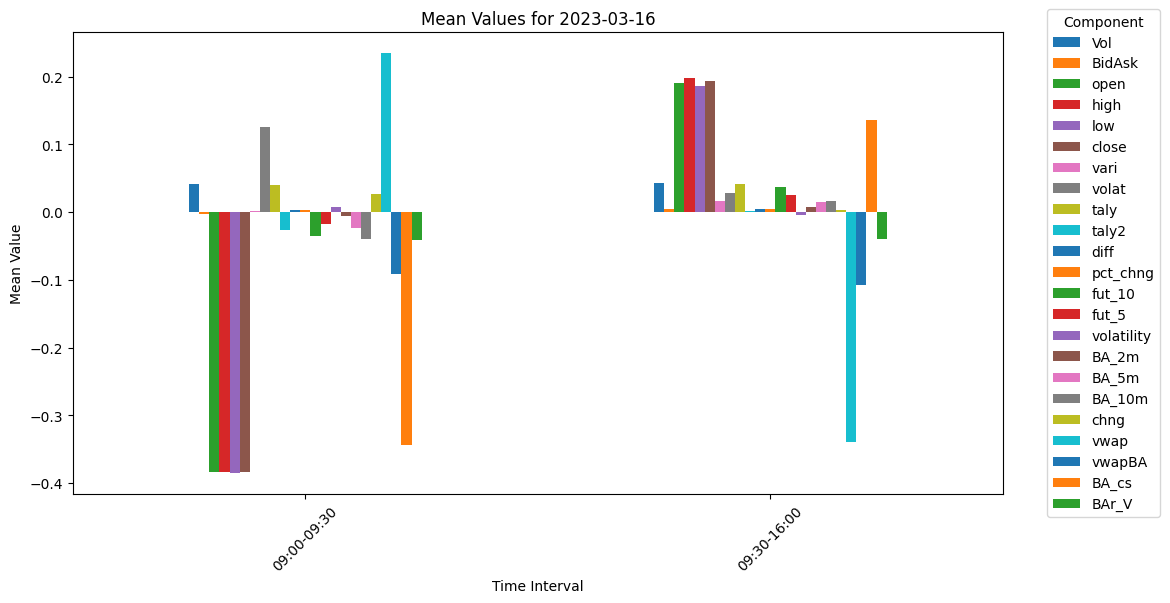

Skipping 2023-03-17 due to insufficient data
Skipping 2023-03-18 due to insufficient data
Skipping 2023-03-19 due to insufficient data
Skipping 2023-03-20 due to insufficient data
Skipping 2023-03-21 due to insufficient data
Skipping 2023-03-22 due to insufficient data
Skipping 2023-03-23 due to insufficient data


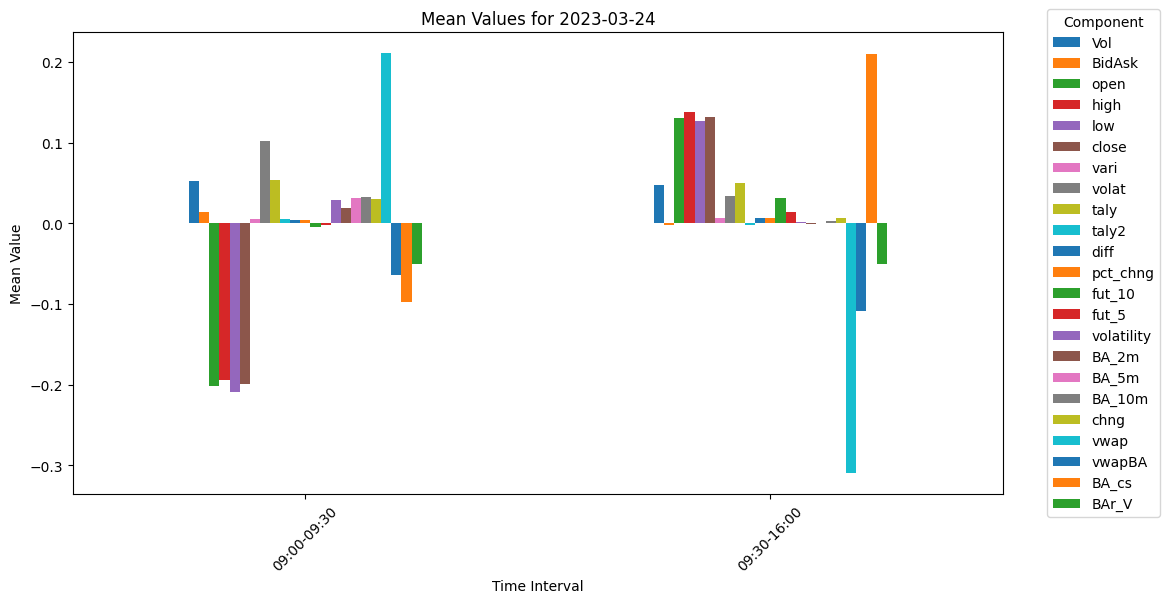

Skipping 2023-03-25 due to insufficient data
Skipping 2023-03-26 due to insufficient data
Skipping 2023-03-27 due to insufficient data
Skipping 2023-03-28 due to insufficient data
Skipping 2023-03-29 due to insufficient data
Skipping 2023-03-30 due to insufficient data


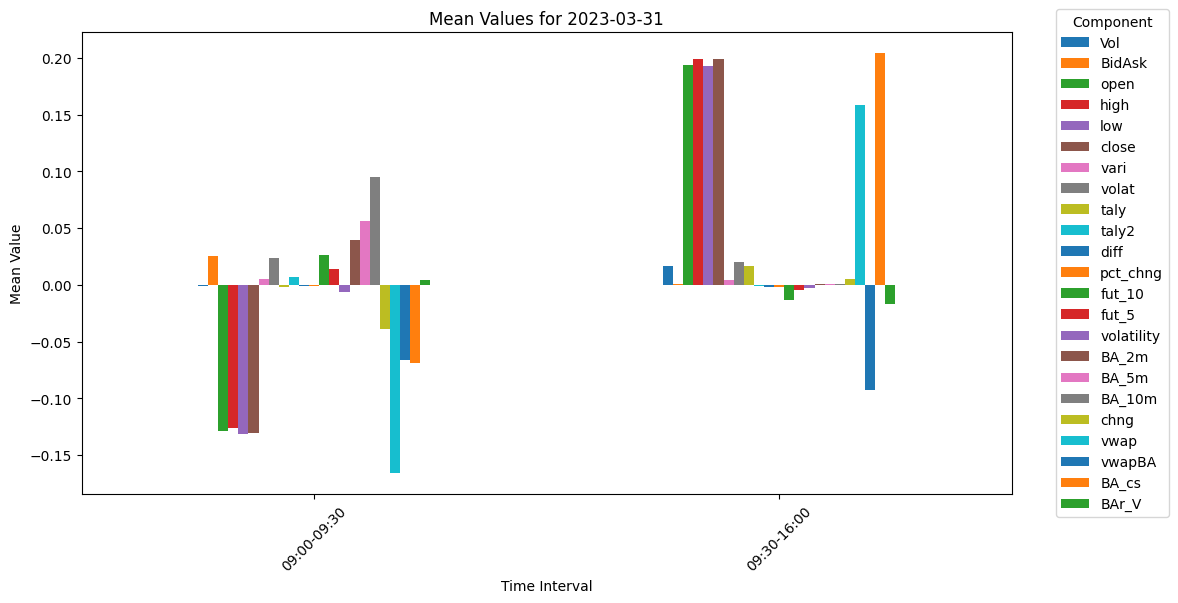

In [102]:

# nq_centered

# Resample the DataFrame into 30-minute intervals and group by day
resampled_df = nq_centered.resample('30T').mean()
grouped_df = resampled_df.groupby(resampled_df.index.date)

# Iterate over the groups
for day, group in grouped_df:
    # Filter the data between 9 am and 9:30 am, and 9:30 am and 4 pm
    interval_9_to_930 = group.between_time('09:00', '09:30').dropna()
    rest_of_day = group.between_time('09:30', '16:00').dropna()

    # Check if both intervals have data
    if interval_9_to_930.empty or rest_of_day.empty:
        # print(f"Skipping {day} due to insufficient data")
        continue

    # Calculate the means for both parts
    mean_9_to_930 = interval_9_to_930.mean()
    mean_rest_of_day = rest_of_day.mean()

    # Combine the means into a new DataFrame
    combined_means = pd.concat([mean_9_to_930, mean_rest_of_day], axis=1).T
    combined_means.index = ['09:00-09:30', '09:30-16:00']

    # Plot the combined means as a bar plot
    combined_means.plot(kind='bar', figsize=(12, 6))
    plt.xlabel("Time Interval")
    plt.ylabel("Mean Value")
    plt.title(f"Mean Values for {day}")
    plt.legend(combined_means.columns, title="Component", bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.xticks(range(len(combined_means.index)), combined_means.index, rotation=45)
    plt.show()


In [29]:
#  Total number of infinite values: 0
nq_centered.sort_index(inplace=True)
# esDown.head()
# esDown.tail(30)
# check for infinite values
mask = nq_centered.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
# print the mask and the number of infinite values
# print(mask)
print(f'Total number of infinite values: {inf_count}') # 0
nq_centered.head()
# esDown = esDown.dropna(axis=0, how='any', subset=['chng'])

# Identify columns with NaN values and count them
nan_columns = nq_centered.isna().any()
# Count the number of NaN values per column
nan_count = nan_columns.isna().sum()
print("Number of NaN values per column:", nan_count)
# Total number of NaN values in the entire DataFrame
total_nan_count = nan_count.sum()
print("\nTotal number of NaN values in the DataFrame:", total_nan_count)

Total number of infinite values: 0
Number of NaN values per column: 0

Total number of NaN values in the DataFrame: 0


In [46]:
nq_centered.columns

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       'taly', 'taly2', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility',
       'BA_2m', 'BA_5m', 'BA_10m', 'chng', 'vwap', 'vwapBA', 'BA_cs', 'BAr_V'],
      dtype='object')

In [45]:
nq_centered.head()
nq_centered.shape

(9882, 23)

In [42]:

# # Create a sample time series DataFrame
# date_rng = pd.date_range(start='2021-01-01', end='2021-01-10', freq='D')
# data = {
#     'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, -np.inf],
#     'B': [np.inf, -np.inf, 3, 4, 5, 6, 7, 8, 9, 10],
#     'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, np.inf]
# }
# df = pd.DataFrame(data, index=date_rng)

# Find the infinite values
infinite_mask = np.isinf(nq_centered)
infinite_positions = np.argwhere(infinite_mask.values)

# Print the columns and time series index of the infinite values
for pos in infinite_positions:
    row, col = pos
    index_value = nq_centered.index[row]
    column_name = nq_centered.columns[col]
    print(f"Infinite value at column '{column_name}', index '{index_value}'")


In [69]:
nq_centered.columns

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
       'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA'],
      dtype='object')

Singular values for the 9-10 hour: [1.88892861e+01 1.21158881e+01 9.17995911e+00 6.50345430e+00
 5.42876594e+00 4.83576986e+00 4.67317548e+00 3.66794427e+00
 3.37606974e+00 3.12594454e+00 3.00300197e+00 2.90801863e+00
 2.44728427e+00 2.20990474e+00 1.96037564e+00 1.71906276e+00
 1.08176942e+00 5.43045988e-01 3.62584154e-01 3.29718323e-01
 2.66795478e-01 2.20408675e-01 1.58675110e-02]
Singular values for the 10-11 hour: [12.00071981 10.35154959  9.27463825  6.43103531  4.92564398  4.25541259
  3.88271447  3.40256862  3.29448547  2.96543186  2.7848176   2.58083176
  2.1045539   1.8895604   1.68446763  1.64313394  1.45329644  0.61864265
  0.31388109  0.27592171  0.22158662  0.19881187  0.01444396]


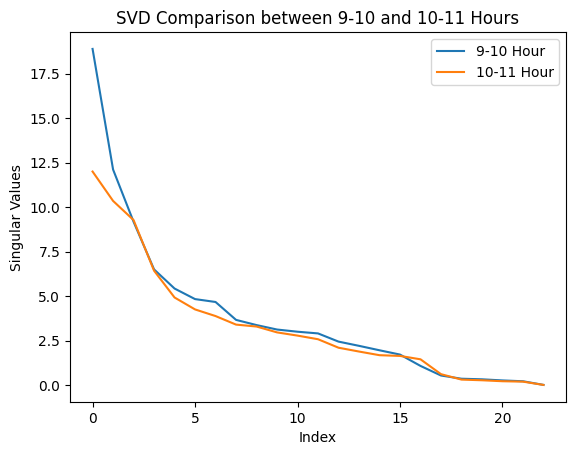

In [70]:
from scipy.linalg import svd
import matplotlib.pyplot as plt

# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = nq_centered.between_time('9:00', '10:00')
df_10_to_11 = nq_centered.between_time('10:00', '11:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_10_to_11, s_10_to_11, Vh_10_to_11 = svd(df_10_to_11)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_10_to_11)

# Plot the SVD values using matplotlib
plt.plot(s_9_to_10, label="9-10 Hour")
plt.plot(s_10_to_11, label="10-11 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 10-11 Hours")
plt.legend()
plt.show()
